In [1]:
import matplotlib.pyplot as plt
from fitting_scripts import (
    fit_odr,
    get_model_odr,
    scifmt,
    labels,
    plot_fitting_mean,
    add_panel_labels,
)
import numpy as np
import os
import pandas as pd
import xarray as xr

from matplotlib.lines import Line2D

import astropy.units as au
import astropy.constants as ac

In [2]:
plt.style.use("presentation-dark.mplstyle")

In [3]:
yield_conv = (
    ((au.cm ** (-3) * au.K * ac.k_B) / (ac.M_sun / ac.kpc**2 / au.yr)).to("km/s").value
)

/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


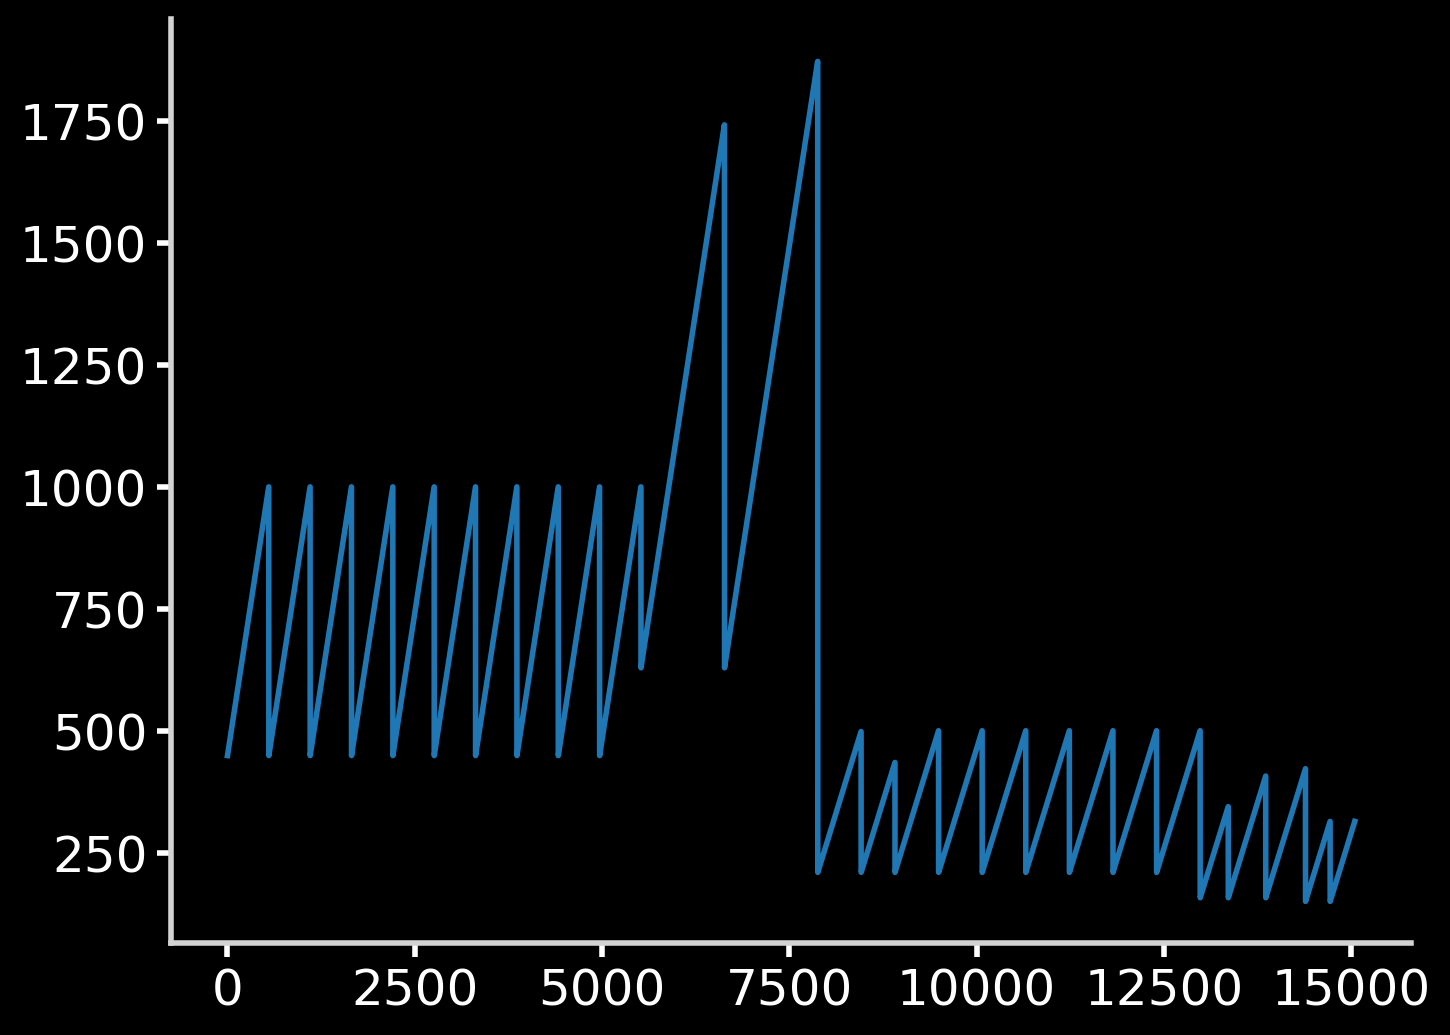

In [4]:
# "pt_df" is a pandas.DataFrame collecting relevant physical quantity time series from
# all simulations into a long-form array
# it will not be straightforward to bundle each model's points from this data
pt_df = pd.read_pickle("points_all.p")
pt_logdf = np.log10(pt_df)

# one can bundle data for each model based on "time_code" field
# that is increasing within each model's data output
plt.plot(pt_df["time_code"])

In [5]:
# "qdset" is a xarray.Dataset storing the (16, 50, 84) percentile values and mean and std for each model's time series into an effectively 3D array.
with xr.open_dataarray("percentiles_all.nc") as qdset:
    # get median values and convert it into pandas.DataFrame
    mid_df = qdset.sel(q="50").to_dataset(dim="variable").drop("q").to_dataframe()
    mid_logdf = np.log10(mid_df)

/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/Users/ckim/miniconda3/envs/prfm/lib/python3.11/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log10
  result = func(self.values, **kwargs)


In [6]:
# these are all quantity name stored in this data
# we are mostly interested in fitting "Yxxx" as a function of "W" and "Zgas"
print(qdset["variable"])

<xarray.DataArray 'variable' (variable: 97)>
array(['Ptot', 'Ytot', 'Ptot_top', 'dPtot', 'Pturb', 'Yturb', 'Pturb_top',
       'dPturb', 'Pth', 'Yth', 'Pth_top', 'dPth', 'Pimag', 'Ymag', 'Pimag_top',
       'dPimag', 'oPimag', 'oYmag', 'oPimag_top', 'doPimag', 'dYmag',
       'dPimag_top', 'ddPimag', 'Prad', 'Yrad', 'Prad_top', 'dPrad',
       'Ptot_hot', 'Ytot_hot', 'Ptot_hot_top', 'dPtot_hot', 'Pturb_hot',
       'Yturb_hot', 'Pturb_hot_top', 'dPturb_hot', 'Pth_hot', 'Yth_hot',
       'Pth_hot_top', 'dPth_hot', 'Pimag_hot', 'Ymag_hot', 'Pimag_hot_top',
       'dPimag_hot', 'oPimag_hot', 'oYmag_hot', 'oPimag_hot_top',
       'doPimag_hot', 'dYmag_hot', 'dPimag_hot_top', 'ddPimag_hot', 'Prad_hot',
       'Yrad_hot', 'Prad_hot_top', 'dPrad_hot', 'Ynonth', 'nH',
       'sigma_eff_mid', 'sigma_eff', 'sigma_turb_mid', 'sigma_turb',
       'sigma_th_mid', 'sigma_th', 'H', 'PDE_whole_approx',
       'PDE_2p_avg_approx', 'PDE_2p_mid_approx', 'PDE_whole_approx_sp',
       'PDE_2p_avg_approx_sp

In [7]:
qdset["name"]

<xarray.DataArray 'name' (name: 26)>
array(['R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps0.0',
       'R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps0.0',
       'R8_8pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy2048.eps0.0',
       'R8_8pc_NCR.full.b10.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0',
       'R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0',
       'R8_8pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0',
       'R8_8pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy2048.eps0.0',
       'R8_8pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy4096.eps0.0',
       'R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy4096.eps0.0',
       'R8_8pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy4096.eps0.0',
       'LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg1.Zd1.xy4096.eps0.0',
       'LGR8_8pc_NCR_S05.full.b10.v3.iCR5.Zg0.1.Zd0.1.xy8192.eps0.0',
       'LGR4_4pc_NCR_S100.full.b1.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01',
       'LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8',
       'LGR4_4pc_NCR_S100.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8',
       'LGR4_4pc_NCR.full.b10.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8',
       'LGR4_4pc_NCR.full.b10.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8',
       'LGR4_4pc_NCR.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps1.e-8',
       'LGR4_4pc_NCR.full.b1.v3.iCR4.Zg0.3.Zd0.3.xy2048.eps1.e-8',
       'LGR4_4pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.1.xy2048.eps1.e-8',
       'LGR4_4pc_NCR.full.b1.v3.iCR4.Zg0.1.Zd0.025.xy2048.eps1.e-8',
       'LGR2_4pc_NCR_S150.full.b2.Om02.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8.rstZ01',
       'LGR2_4pc_NCR_S150.full.b2.Om02.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8',
       'LGR2_4pc_NCR_S150.full.b2.Om02.v3.iCR5.Zg0.1.Zd0.1.xy2048.eps1.e-8',
       'LGR2_4pc_NCR_S150.full.b2.Om01.q0.v3.iCR5.Zg0.1.Zd0.1.xy2048.eps1.e-8',
       'LGR2_4pc_NCR_S150.full.b2.Om01.q0.v3.iCR5.Zg1.Zd1.xy1024.eps1.e-8'],
      dtype=object)
Coordinates:
  * name     (name) object 'R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Zd1.xy1024.eps...

In [8]:
# nsel=[]
# for n in qdset['name'].data:
#     if ('R8_8pc_NCR.full.b10' in n or
#         'LGR4_4pc_NCR.full.b10' in n or
#         'rstZ01' in n):
#         print(n)
#     else:
#         nsel.append(n)

In [9]:
# qdset = qdset.sel(name=nsel)

# fitting with mean and std

In [10]:
# We are fitting variables as a function of "W" and "Zgas"
# I set the parameter range of interest (in log scale) here
Zmin = -1.3
Zmax = 0.3
Wmin = 2.7
Wmax = 6.3

In [11]:
# setup figure output directory
outdir = "./lowZ-figures-talk/"
os.makedirs(outdir, exist_ok=True)
# outdir = '/tigress/changgoo/public_html/TIGRESS-NCR/lowZ-figures/'

Beta: [4.17345707 1.18929952 0.01979326]
Beta Std Error: [0.03131637 0.02678829 0.036687  ]
Beta Covariance: [[ 0.31199161 -0.15447087  0.24742547]
 [-0.15447087  0.22829173 -0.04114853]
 [ 0.24742547 -0.04114853  0.42817833]]
Residual Variance: 0.0031434012350536164
Inverse Condition #: 0.041722293356577726
Reason(s) for Halting:
  Sum of squares convergence
L1 : 0.13992887989742095
L2 : 0.19276914439416143


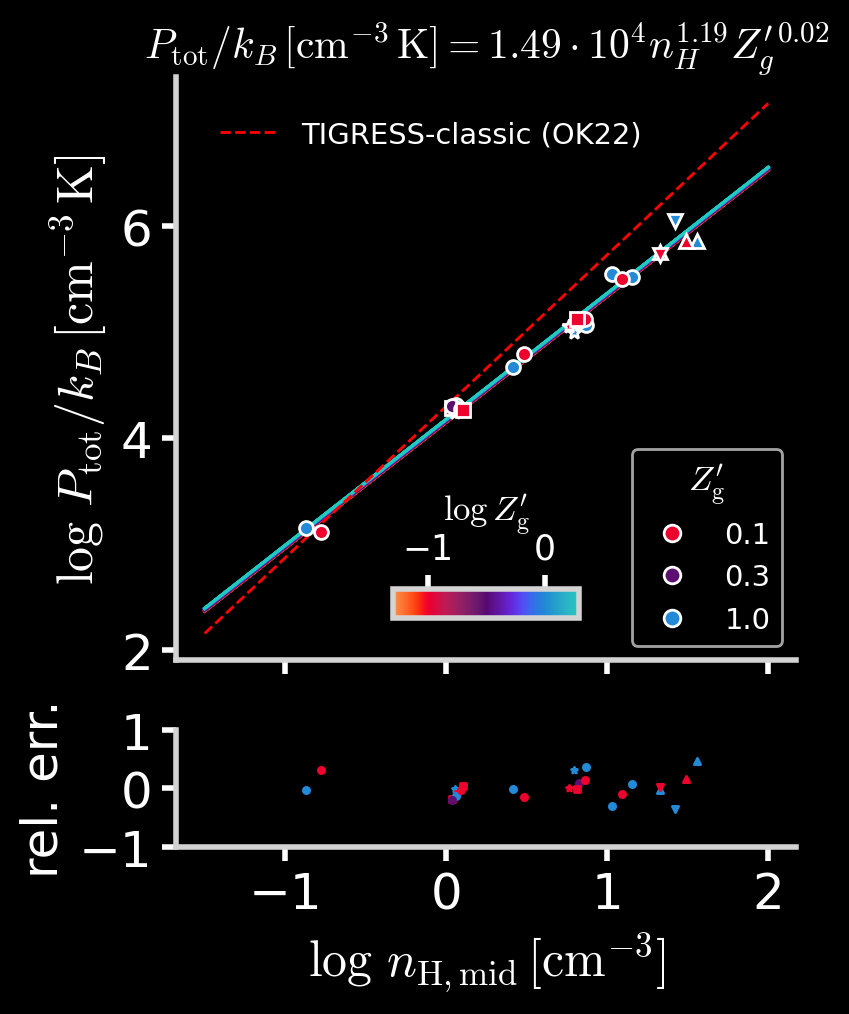

In [12]:
# Figure for the effective Equation of State (eEOS)
fig, axes = plt.subplots(
    2, 1, sharex="col", figsize=(4, 5), gridspec_kw=dict(height_ratios=[1, 0.2])
)

# set field names for x-axes and yaxis
# here we fit Ptot as a function of nH and Zgas
x1, x2, yf = ["nH", "Zgas", "Ptot"]

# linear regression
odr_out = fit_odr(qdset, xf1=x1, xf2=x2, yf=yf)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset = get_model_odr(
    odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=-1.5, Wmax=2, dims=[x2, x1]
)

# plot simulation data along with fitting result
plt.sca(axes[0])
# write fitting result as the axis title
a = odr_out.beta[1]
b = odr_out.beta[2]
Y0 = 10 ** odr_out.beta[0]
tit = labels[yf] + f"$={scifmt(Y0)} n_H^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$"
plt.title(tit, fontsize="small")

# call plotting script
plot_fitting_mean(qdset, model_dset, x1, yf, legend=4, colorbar=8, model=True)
# plot all data as grey dots
# plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
plt.xlabel("")

# plot residual compared with the fitting result
plt.sca(axes[1])
plot_fitting_mean(qdset, model_dset, x1, yf, residual=True, model=True)

# add reference line from the previous result (Ostriker & Kim 2022 Eq 27, Figure 14)
nH = model_dset.nH.data
plt.sca(axes[0])
plt.plot(nH, 4.3 + nH * 1.43, ls="--", color="r", lw=1)
leg1 = plt.gca().get_legend()
custom_lines2 = [Line2D([0], [0], ls="--", color="r", lw=1)]
leg2 = plt.legend(
    custom_lines2,
    ["TIGRESS-classic (OK22)"],
    loc=2,
    borderpad=1,
    fontsize="xx-small",
    frameon=False,
)
plt.gca().add_artist(leg1)

# decorate axis
fig.axes[-1].xaxis.set_ticks_position("top")
fig.axes[-1].xaxis.set_label_position("top")
plt.setp(fig.axes[-1].get_xticklabels(), "fontsize", "x-small")
fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(), fontsize="x-small")

# save figure
plt.savefig(os.path.join(outdir, "eEOS_fit.png"), bbox_inches="tight")

In [13]:
qdset.to_dataset("variable")

<xarray.Dataset>
Dimensions:               (name: 26, q: 5)
Coordinates:
  * name                  (name) object 'R8_8pc_NCR_S30.full.b1.v3.iCR4.Zg1.Z...
  * q                     (q) object '16' '50' '84' 'mean' 'std'
Data variables: (12/97)
    Ptot                  (name, q) float64 ...
    Ytot                  (name, q) float64 ...
    Ptot_top              (name, q) float64 ...
    dPtot                 (name, q) float64 ...
    Pturb                 (name, q) float64 ...
    Yturb                 (name, q) float64 ...
    ...                    ...
    tdep10                (name, q) float64 ...
    tdep40                (name, q) float64 ...
    tdep100               (name, q) float64 ...
    Zgas                  (name, q) float64 ...
    Zdust                 (name, q) float64 ...
    PDE                   (name, q) float64 ...

Beta: [0.60903547 0.11697901 0.04283688]
Beta Std Error: [0.0510918  0.01017369 0.01596411]
Beta Covariance: [[ 1.83493961 -0.35659178  0.15445207]
 [-0.35659178  0.07275725 -0.01267402]
 [ 0.15445207 -0.01267402  0.17914661]]
Residual Variance: 0.001422592693929469
Inverse Condition #: 0.0032222813463850947
Reason(s) for Halting:
  Sum of squares convergence
L1 : 0.06347587906604467
L2 : 0.08160536082242482


Text(0.5, 0, '$\\log$$Z_{\\rm g}^\\prime$')

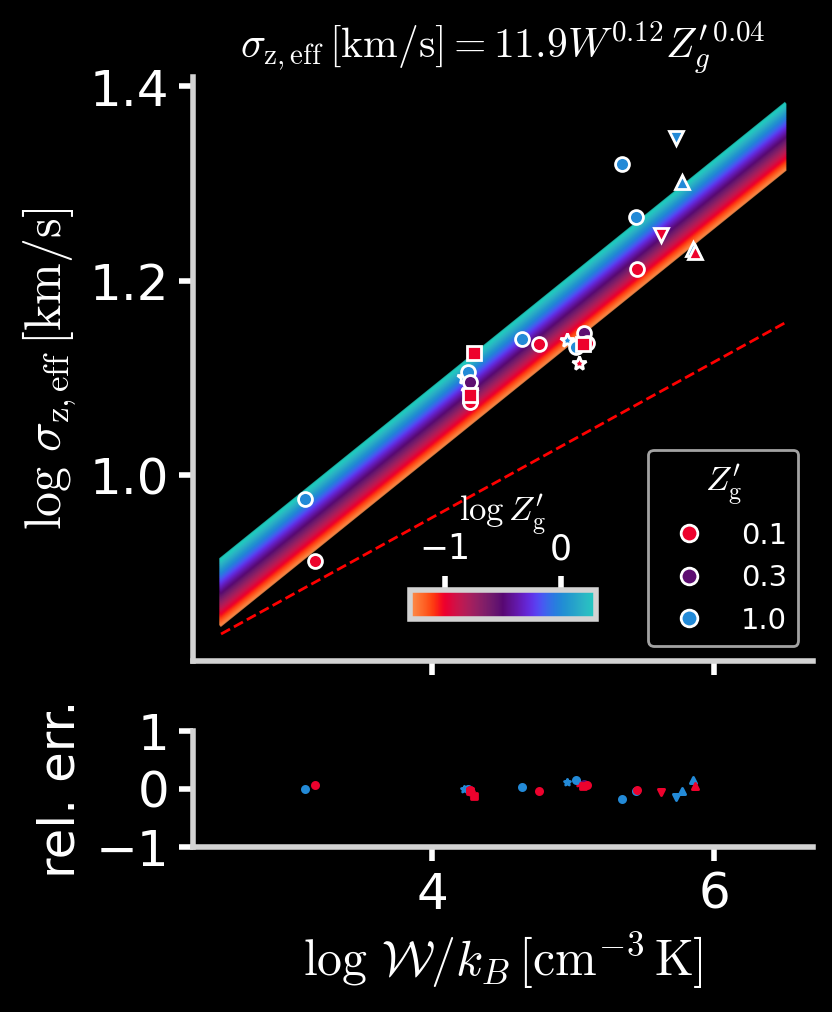

In [14]:
# Figure for the effective Equation of State (eEOS)
fig, axes = plt.subplots(
    2, 1, sharex="col", figsize=(4, 5), gridspec_kw=dict(height_ratios=[1, 0.2])
)

# set field names for x-axes and yaxis
# here we fit Ptot as a function of nH and Zgas
x1, x2, yf = ["W", "Zgas", "sigma_eff"]

# linear regression
odr_out = fit_odr(qdset, xf1=x1, xf2=x2, yf=yf)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset = get_model_odr(odr_out, Zmin=Zmin, Zmax=Zmax, dims=[x2, x1])

# plot simulation data along with fitting result
plt.sca(axes[0])
# write fitting result as the axis title
a = odr_out.beta[1]
b = odr_out.beta[2]
Y0 = 10 ** odr_out.beta[0] * 1.0e4**a
tit = labels[yf] + f"$={scifmt(Y0)} W^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$"
plt.title(tit, fontsize="small")

# call plotting script
plot_fitting_mean(qdset, model_dset, x1, yf, legend=4, colorbar=8, model=True)
# plot all data as grey dots
# plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
plt.xlabel("")

# plot residual compared with the fitting result
plt.sca(axes[1])
plot_fitting_mean(qdset, model_dset, x1, yf, residual=True, model=True)

# add reference line from the previous result (Ostriker & Kim 2022 Eq 27, Figure 14)
W = model_dset.W.data
plt.sca(axes[0])
plt.plot(W, np.log10(9.05) + 0.08 * (W - 4), ls="--", color="r", lw=1)
# leg1=plt.gca().get_legend()
# custom_lines2 = [Line2D([0], [0], ls = '--', color='r', lw=1)]
# leg2 = plt.legend(custom_lines2,['TIGRESS-classic (OK22)'],loc=2,borderpad=1,fontsize='xx-small',frameon=False)
# plt.gca().add_artist(leg1)

# decorate axis
fig.axes[-1].xaxis.set_ticks_position("top")
fig.axes[-1].xaxis.set_label_position("top")
plt.setp(fig.axes[-1].get_xticklabels(), "fontsize", "x-small")
fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(), fontsize="x-small")

# save figure
# plt.savefig(os.path.join(outdir,'eEOS_fit.png'),bbox_inches='tight')

In [15]:
12 * 100**0.22

33.050744440058

Beta: [-0.10158437  1.03647184  0.05385303]
Beta Std Error: [0.08794104 0.01751219 0.02745639]
Beta Covariance: [[ 3.75938826 -0.73064249  0.31605924]
 [-0.73064249  0.1490784  -0.02594831]
 [ 0.31605924 -0.02594831  0.36645505]]
Residual Variance: 0.002057150456822431
Inverse Condition #: 0.0032198765333526394
Reason(s) for Halting:
  Sum of squares convergence
L1 : 0.14068531068989737
L2 : 0.26567664628139515
Beta: [-0.03296514  0.99720305  0.00944269]
Beta Std Error: [0.07679373 0.01529174 0.02398046]
Beta Covariance: [[ 3.60854981 -0.70129176  0.30356094]
 [-0.70129176  0.14308522 -0.02493052]
 [ 0.30356094 -0.02493052  0.35188123]]
Residual Variance: 0.0016342514005256868
Inverse Condition #: 0.0032202967391169474
Reason(s) for Halting:
  Sum of squares convergence
L1 : 0.12892590851699676
L2 : 0.15235155971145461
Beta: [ 0.35201946  0.91736114 -0.05201664]
Beta Std Error: [0.05599715 0.01115034 0.01749089]
Beta Covariance: [[ 3.33495058 -0.64809902  0.28073327]
 [-0.64809902  0.1

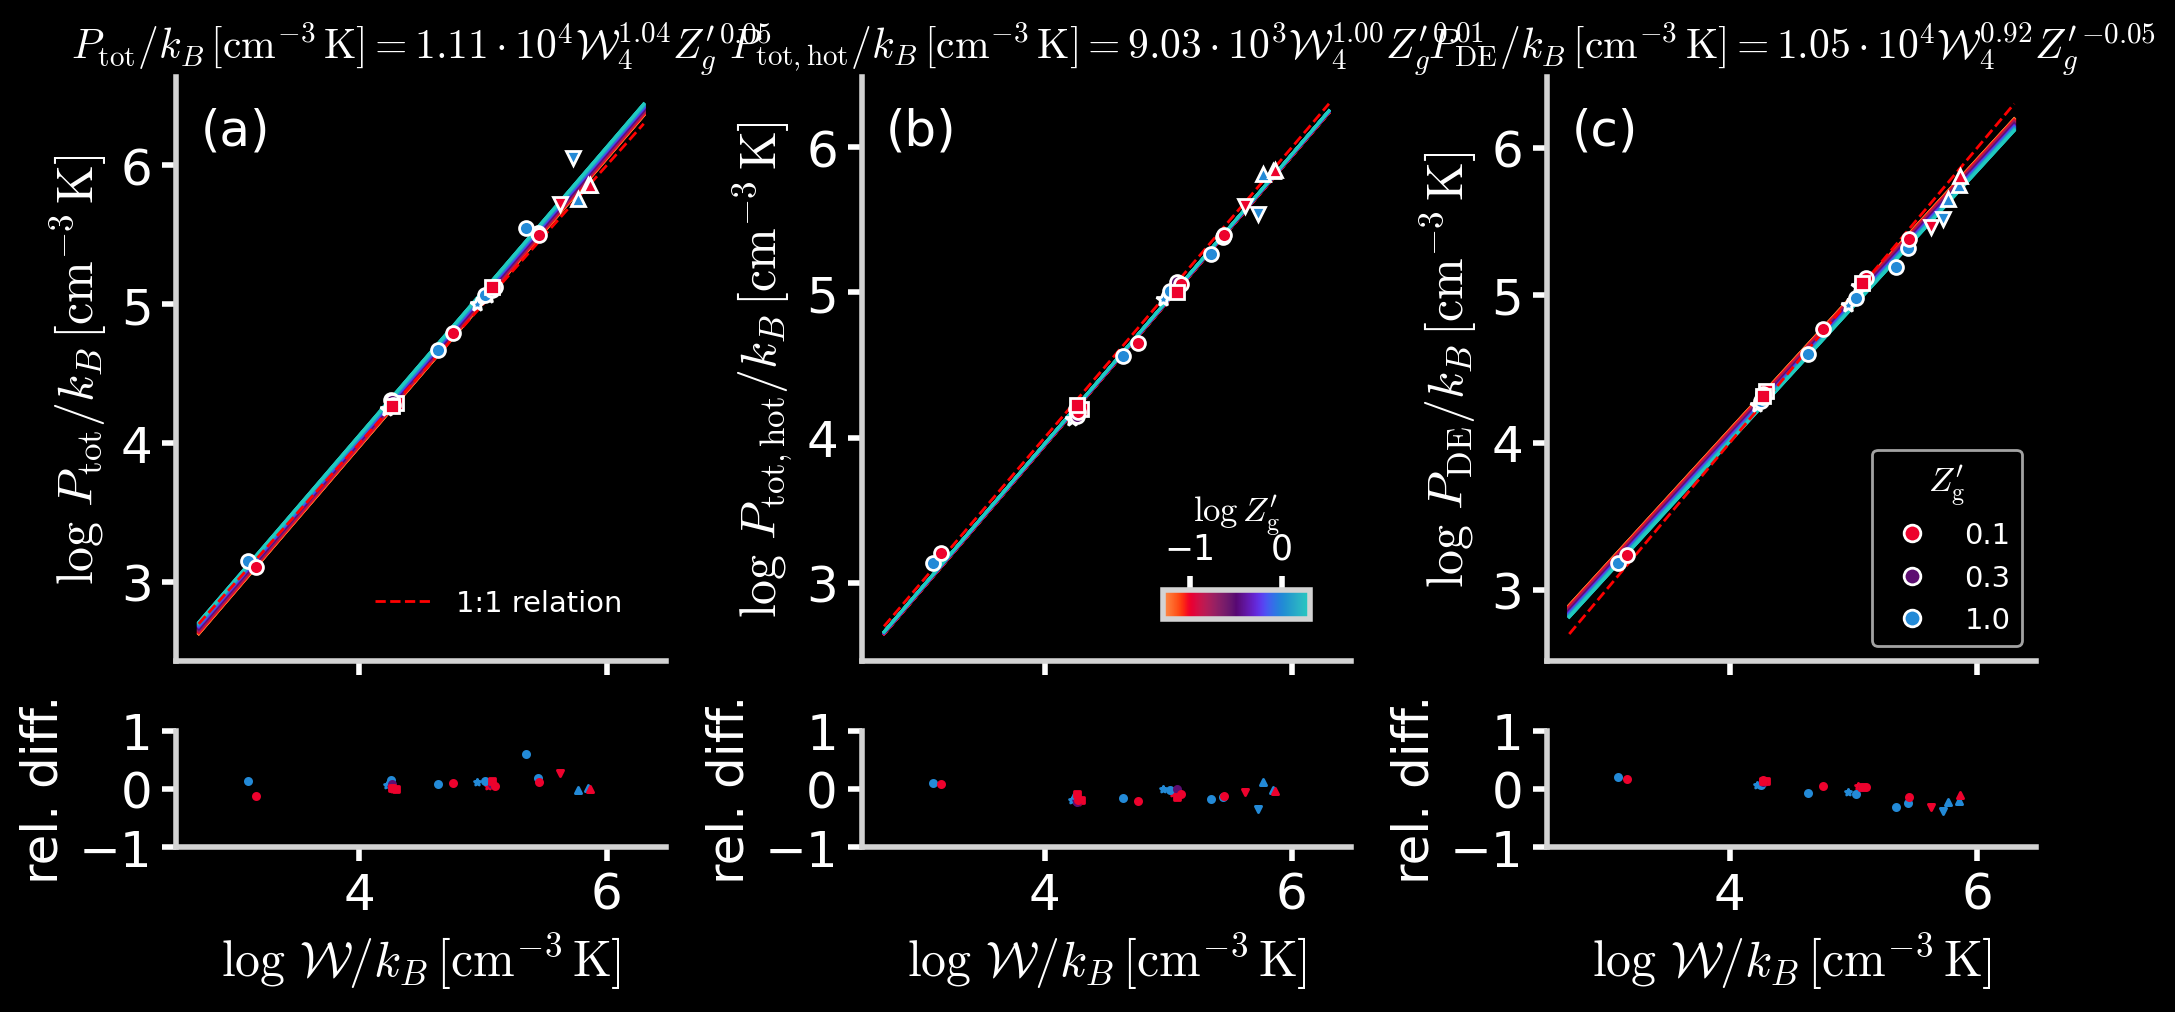

In [16]:
# Figure for
# (a) vertical dynamical equilibrium (Ptot vs W)
# (b) pressure equilibrium between phases (Ptot_hot vs W)
# (c) comparison with analytic weight estimator (PDE from Equation 7 in Ostriker & Kim 2022 vs W)
fig, axes_ = plt.subplots(
    2,
    3,
    sharex="col",
    figsize=(12, 5),
    gridspec_kw=dict(height_ratios=[1, 0.2], wspace=0.4, hspace=0.2),
)

# set field names for x-axes
x1, x2 = ["W", "Zgas"]
for yf, axes in zip(["Ptot", "Ptot_hot", "PDE_2p_avg_approx"], axes_.T):
    # linear regression
    odr_out = fit_odr(qdset, xf1=x1, xf2=x2, yf=yf)
    # construct model (not the x1-axis is not W and the parameter range is changed)
    model_dset = get_model_odr(
        odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=Wmin, Wmax=Wmax, dims=[x2, x1]
    )

    # plot simulation data along with fitting result
    plt.sca(axes[0])

    # write fitting result as the axis title
    a = odr_out.beta[1]
    b = odr_out.beta[2]
    Y0 = 10 ** odr_out.beta[0] * 1.0e4**a
    l = labels[yf] if yf in labels else labels["PDE"]
    tit = (
        l + f"$={scifmt(Y0)} \\mathcal{{W}}_4^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$"
    )
    plt.title(tit, fontsize="small")

    # call plotting script
    sm = plot_fitting_mean(
        qdset,
        model_dset,
        x1,
        yf,
        legend=4 if yf.startswith("PDE") else 0,
        colorbar=4 if yf.startswith("Ptot_hot") else 0,
        model=True,
    )
    # plot one-to-one line
    plt.plot(model_dset.W, model_dset.W, lw=1, ls="--", color="r")
    # plot all data points as grey dots
    # plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
    plt.xlabel("")
    # plt.ylim(3.e2,3.e6)

    # plot residual by comparing x and y field (not comparing with model; model = False)
    plt.sca(axes[1])
    plot_fitting_mean(qdset, model_dset, x1, yf, residual=True, model=False)

# decorate figure
fig.axes[-1].xaxis.set_ticks_position("top")
fig.axes[-1].xaxis.set_label_position("top")
plt.setp(fig.axes[-1].get_xticklabels(), "fontsize", "x-small")
fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(), fontsize="x-small")

# add custom legend
plt.sca(axes_[0, 0])
custom_lines2 = [Line2D([0], [0], ls="--", color="r", lw=1)]
leg2 = plt.legend(
    custom_lines2,
    ["1:1 relation"],
    loc=4,
    borderpad=1,
    fontsize="xx-small",
    frameon=False,
)

# add panel label (a), (b), ...
add_panel_labels(axes_[0, :])

# save figure
plt.savefig(os.path.join(outdir, "PW_fit.png"), bbox_inches="tight")

Beta: [-0.10158437  1.03647184  0.05385303]
Beta Std Error: [0.08794104 0.01751219 0.02745639]
Beta Covariance: [[ 3.75938826 -0.73064249  0.31605924]
 [-0.73064249  0.1490784  -0.02594831]
 [ 0.31605924 -0.02594831  0.36645505]]
Residual Variance: 0.002057150456822431
Inverse Condition #: 0.0032198765333526394
Reason(s) for Halting:
  Sum of squares convergence
L1 : 0.14068531068989737
L2 : 0.26567664628139515
Beta: [-0.03296514  0.99720305  0.00944269]
Beta Std Error: [0.07679373 0.01529174 0.02398046]
Beta Covariance: [[ 3.60854981 -0.70129176  0.30356094]
 [-0.70129176  0.14308522 -0.02493052]
 [ 0.30356094 -0.02493052  0.35188123]]
Residual Variance: 0.0016342514005256868
Inverse Condition #: 0.0032202967391169474
Reason(s) for Halting:
  Sum of squares convergence
L1 : 0.12892590851699676
L2 : 0.15235155971145461
Beta: [ 0.26128464  0.94515413 -0.03040728]
Beta Std Error: [0.0312878  0.00623015 0.00977535]
Beta Covariance: [[ 3.42337257 -0.66527475  0.28818486]
 [-0.66527475  0.1

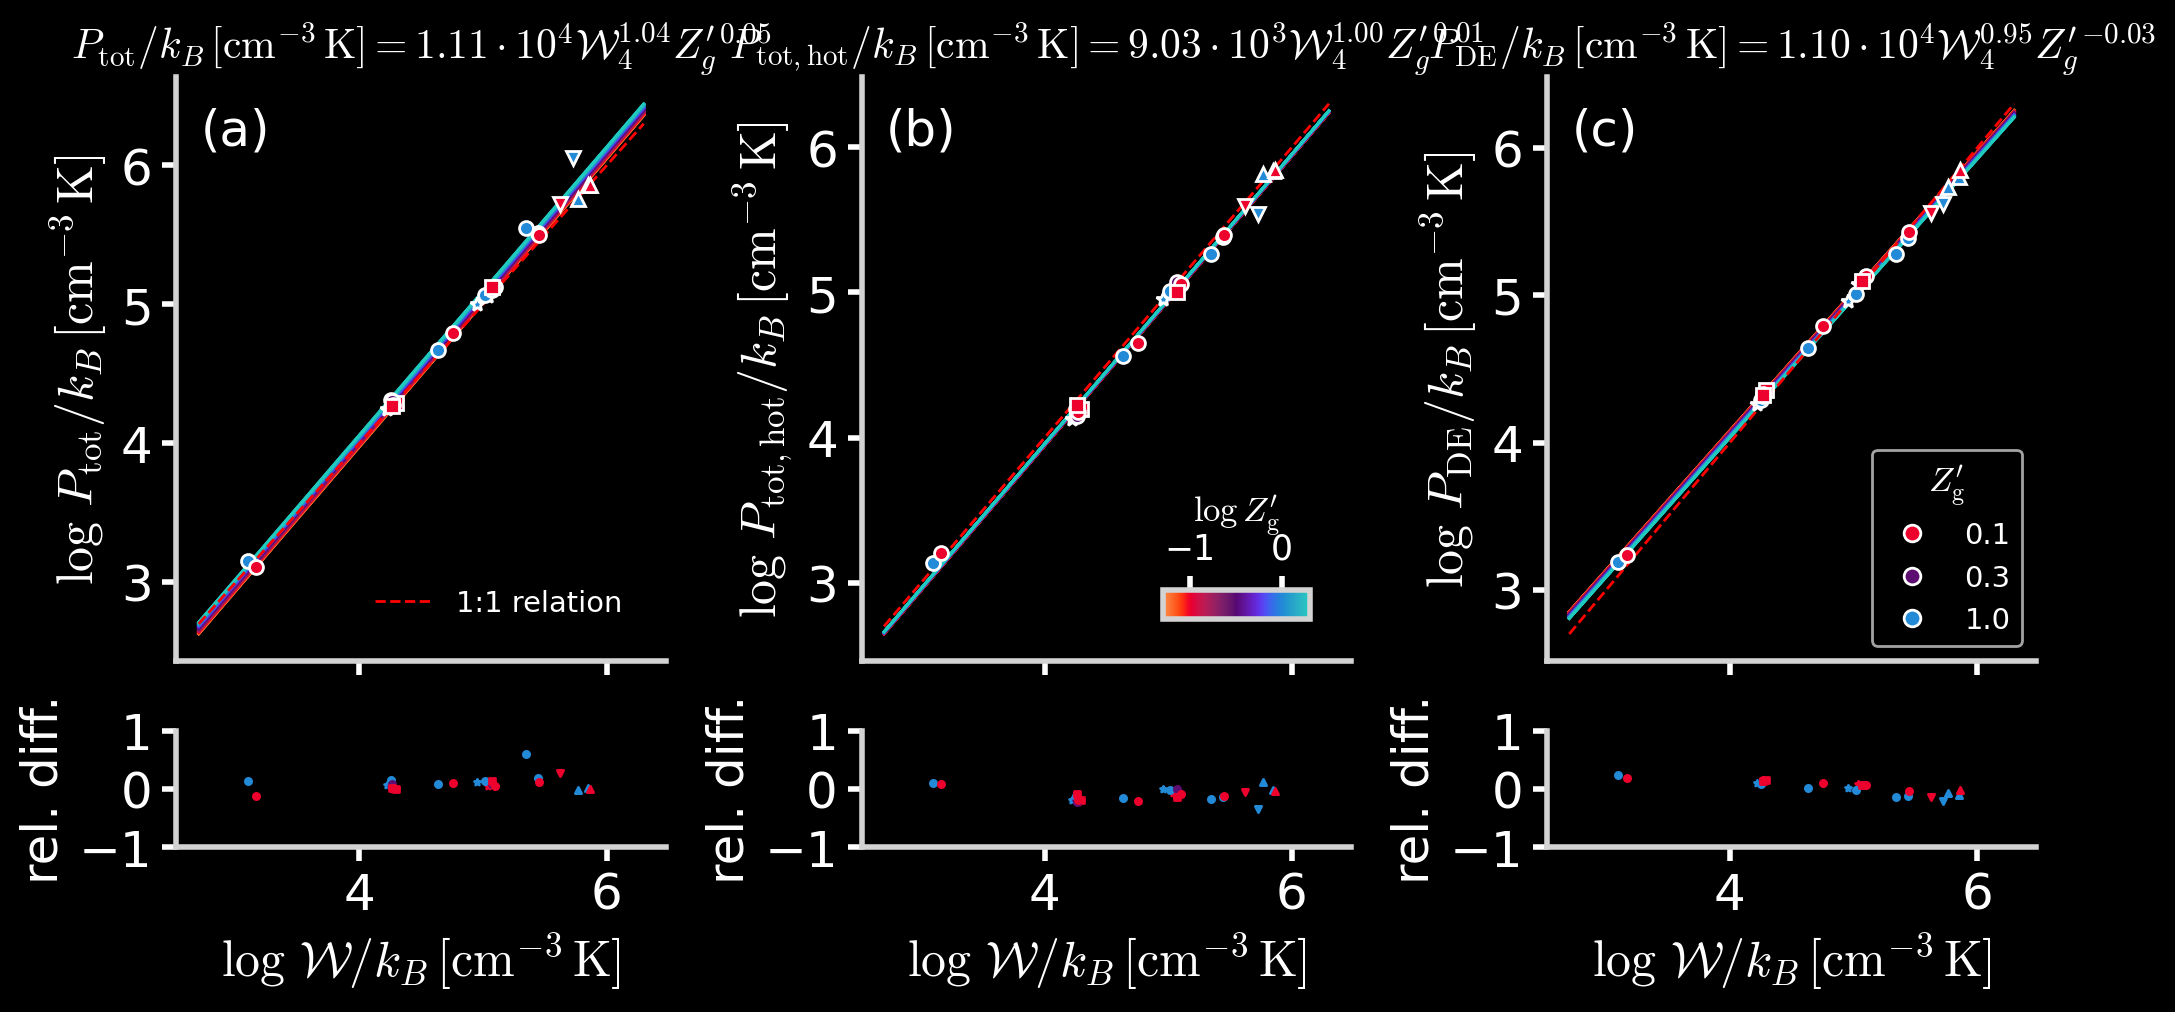

In [17]:
# Figure for
# (a) vertical dynamical equilibrium (Ptot vs W)
# (b) pressure equilibrium between phases (Ptot_hot vs W)
# (c) comparison with analytic weight estimator (PDE from Equation 7 in Ostriker & Kim 2022 vs W)
fig, axes_ = plt.subplots(
    2,
    3,
    sharex="col",
    figsize=(12, 5),
    gridspec_kw=dict(height_ratios=[1, 0.2], wspace=0.4, hspace=0.2),
)

# set field names for x-axes
x1, x2 = ["W", "Zgas"]
for yf, axes in zip(["Ptot", "Ptot_hot", "PDE_2p_avg_approx_sp"], axes_.T):
    # linear regression
    odr_out = fit_odr(qdset, xf1=x1, xf2=x2, yf=yf)
    # construct model (not the x1-axis is not W and the parameter range is changed)
    model_dset = get_model_odr(
        odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=Wmin, Wmax=Wmax, dims=[x2, x1]
    )

    # plot simulation data along with fitting result
    plt.sca(axes[0])

    # write fitting result as the axis title
    a = odr_out.beta[1]
    b = odr_out.beta[2]
    Y0 = 10 ** odr_out.beta[0] * 1.0e4**a
    l = labels[yf] if yf in labels else labels["PDE"]
    tit = (
        l + f"$={scifmt(Y0)} \\mathcal{{W}}_4^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$"
    )
    plt.title(tit, fontsize="small")

    # call plotting script
    sm = plot_fitting_mean(
        qdset,
        model_dset,
        x1,
        yf,
        legend=4 if yf.startswith("PDE") else 0,
        colorbar=4 if yf.startswith("Ptot_hot") else 0,
        model=True,
    )
    # plot one-to-one line
    plt.plot(model_dset.W, model_dset.W, lw=1, ls="--", color="r")
    # plot all data points as grey dots
    # plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
    plt.xlabel("")
    # plt.ylim(3.e2,3.e6)

    # plot residual by comparing x and y field (not comparing with model; model = False)
    plt.sca(axes[1])
    plot_fitting_mean(qdset, model_dset, x1, yf, residual=True, model=False)

# decorate figure
fig.axes[-1].xaxis.set_ticks_position("top")
fig.axes[-1].xaxis.set_label_position("top")
plt.setp(fig.axes[-1].get_xticklabels(), "fontsize", "x-small")
fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(), fontsize="x-small")

# add custom legend
plt.sca(axes_[0, 0])
custom_lines2 = [Line2D([0], [0], ls="--", color="r", lw=1)]
leg2 = plt.legend(
    custom_lines2,
    ["1:1 relation"],
    loc=4,
    borderpad=1,
    fontsize="xx-small",
    frameon=False,
)

# add panel label (a), (b), ...
add_panel_labels(axes_[0, :])

# save figure
plt.savefig(os.path.join(outdir, "PW_fit_sp.png"), bbox_inches="tight")

Beta: [ 4.76023794 -0.35194854 -0.32422181]
Beta Std Error: [0.23024871 0.0458807  0.07214988]
Beta Covariance: [[ 2.22381337 -0.43243281  0.1847976 ]
 [-0.43243281  0.08830068 -0.01472718]
 [ 0.1847976  -0.01472718  0.21836106]]
Residual Variance: 0.023839441040715247
Inverse Condition #: 0.0032245269860820946
Reason(s) for Halting:
  Sum of squares convergence
Ytot
L1 : 0.32188815821013006
L2 : 0.41845636103640804
Beta: [ 4.77950416 -0.52648525 -0.59328959]
Beta Std Error: [0.15702446 0.03128174 0.04920867]
Beta Covariance: [[ 2.94562524 -0.57264518  0.24604994]
 [-0.57264518  0.1169027  -0.01976642]
 [ 0.24604994 -0.01976642  0.28928509]]
Residual Variance: 0.00837061058881952
Inverse Condition #: 0.0032243147102871783
Reason(s) for Halting:
  Sum of squares convergence
Yth
L1 : 0.20756684417268678
L2 : 0.2906420755480598
Beta: [ 4.01246862 -0.2781657  -0.07078362]
Beta Std Error: [0.26847271 0.0534773  0.08376508]
Beta Covariance: [[ 1.96227562 -0.3814894   0.16400648]
 [-0.3814894

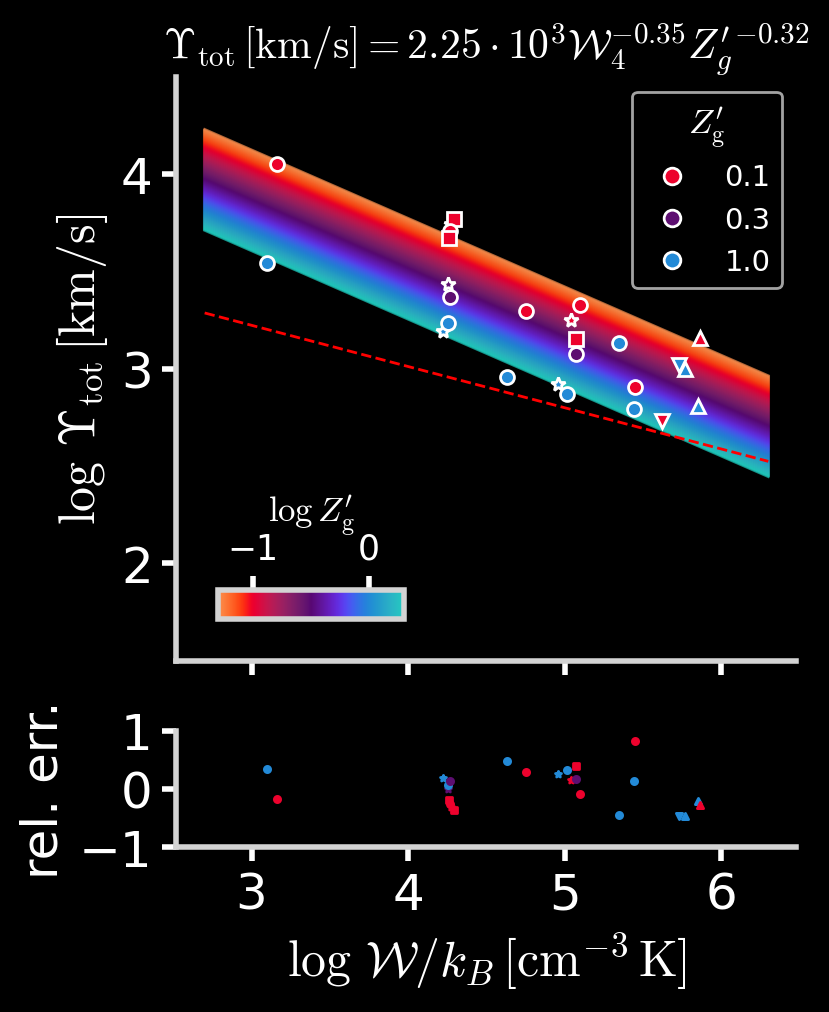

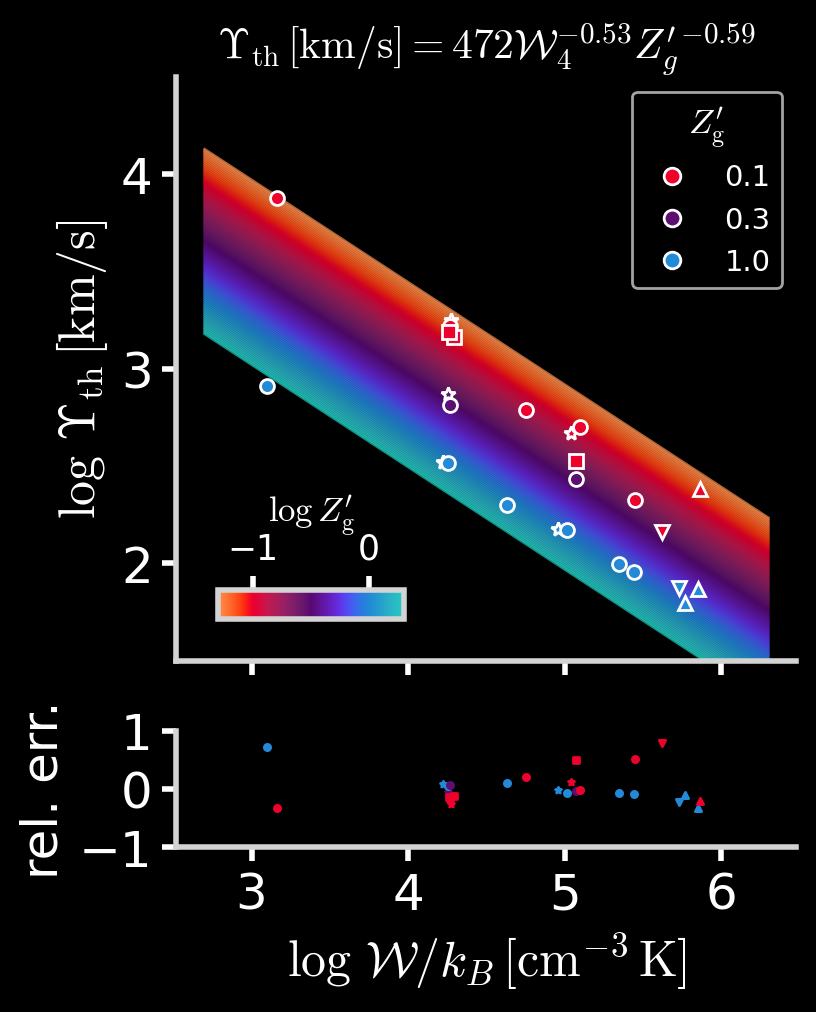

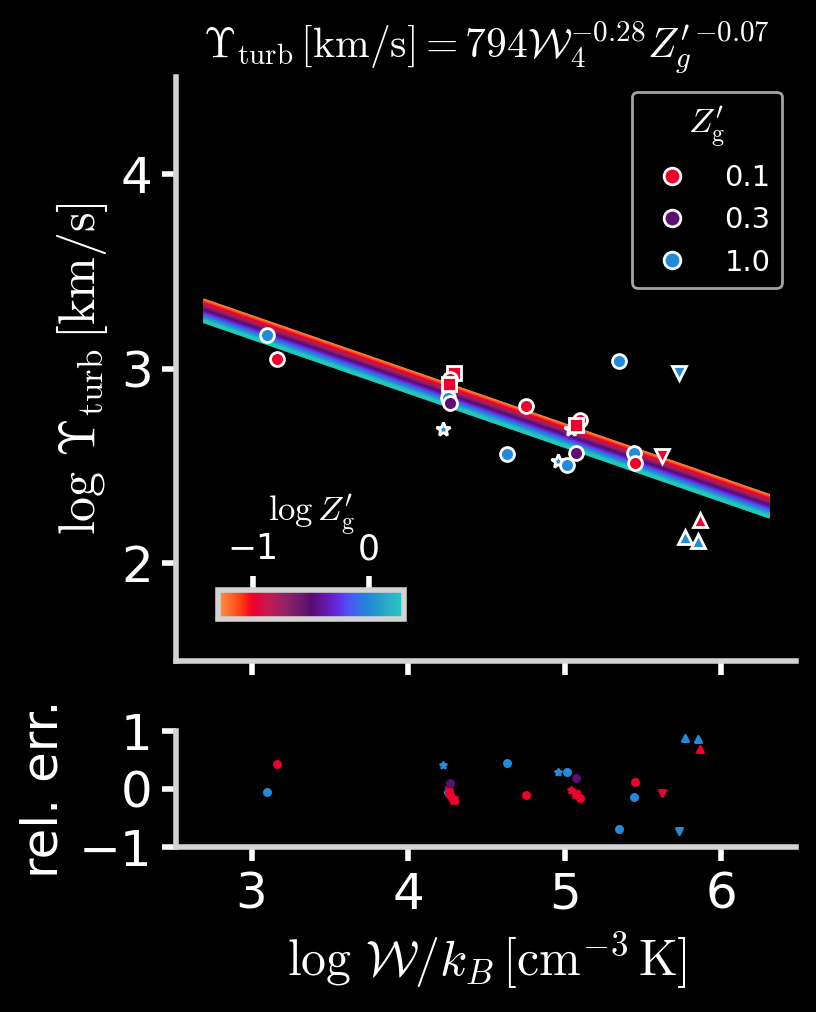

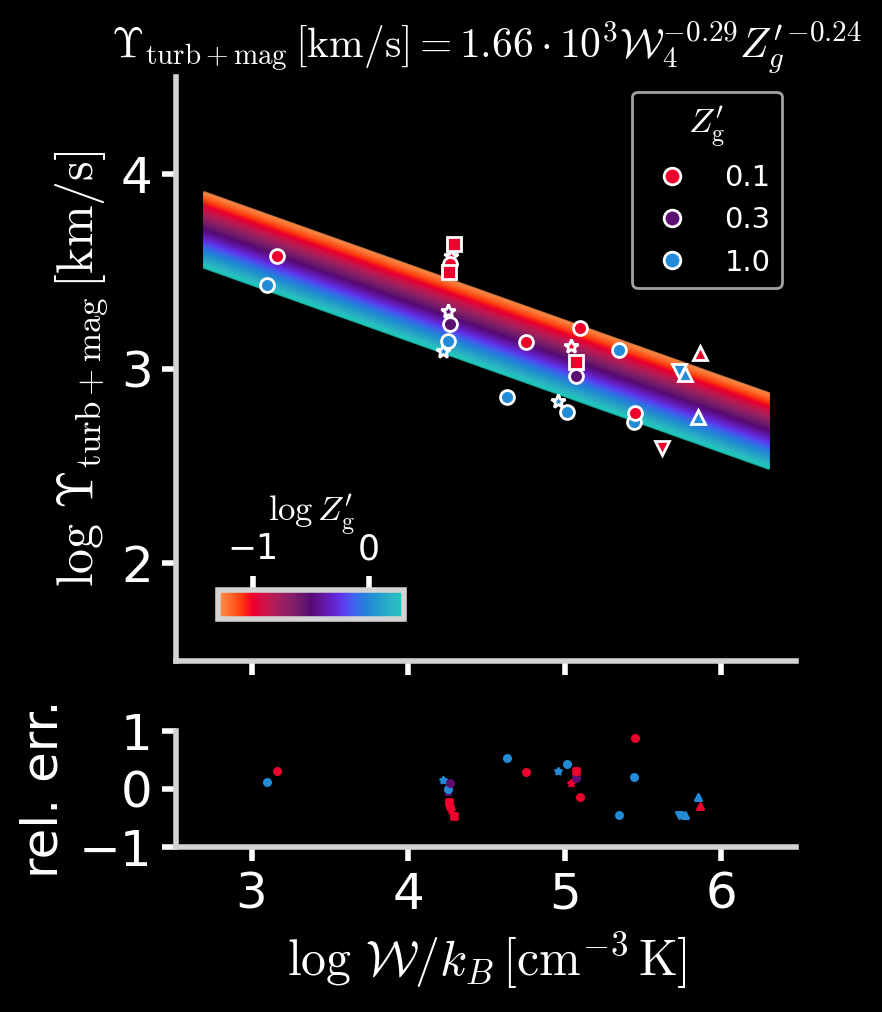

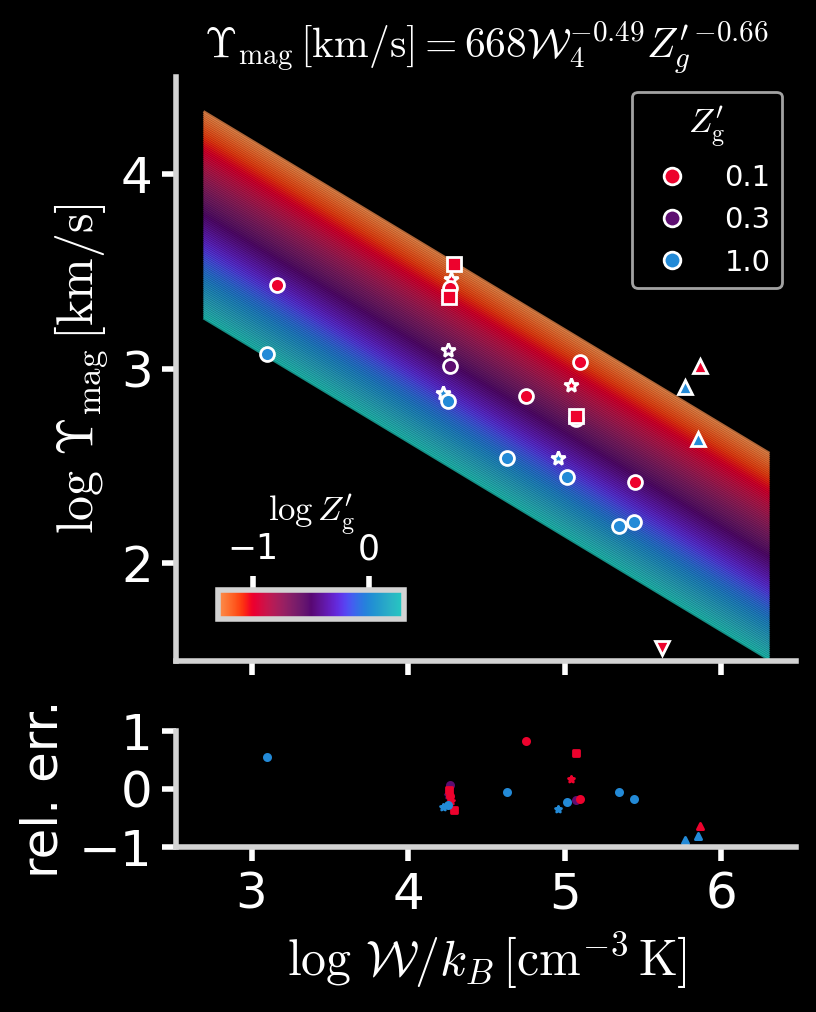

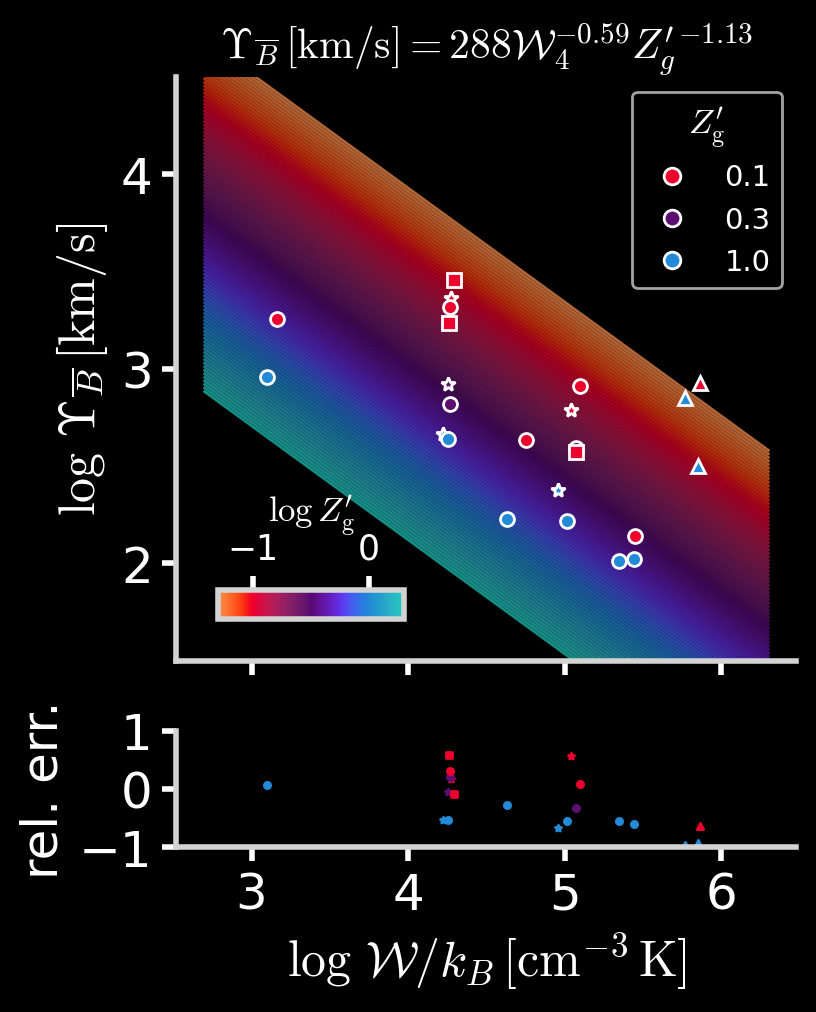

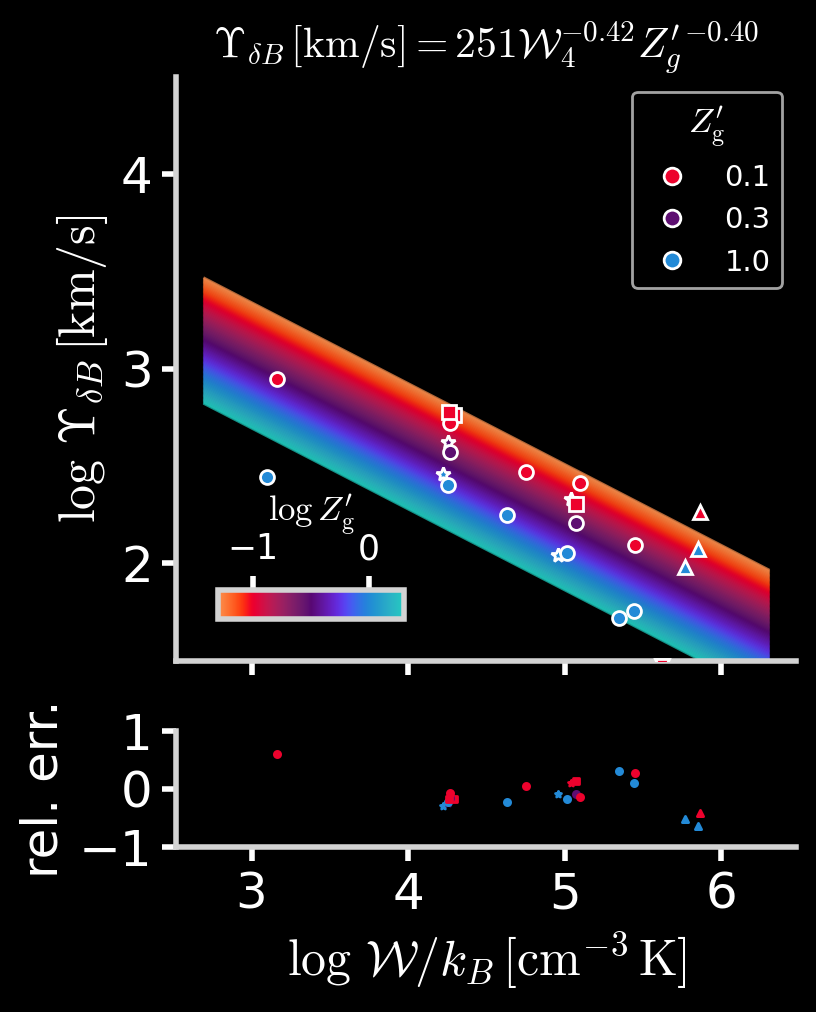

In [18]:
# Figure for feedback yields (each component saved into each figure)
for yf in ["Ytot", "Yth", "Yturb", "Ynonth", "Ymag", "oYmag", "dYmag"]:
    fig, axes = plt.subplots(
        2, 1, sharex="col", figsize=(4, 5), gridspec_kw=dict(height_ratios=[1, 0.2])
    )

    # set field names for x-axes and yaxis
    x1, x2 = ["W", "Zgas"]

    # linear regression
    odr_out = fit_odr(qdset, xf1=x1, xf2=x2, yf=yf)
    # construct model (not the x1-axis is not W and the parameter range is changed)
    model_dset = get_model_odr(
        odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=Wmin, Wmax=Wmax, dims=[x2, x1]
    )

    # plot simulation data along with fitting result
    plt.sca(axes[0])

    # write fitting result as the axis title
    a = odr_out.beta[1]
    b = odr_out.beta[2]
    Y0 = 10 ** odr_out.beta[0] * 1.0e4**a
    tit = (
        labels[yf]
        + f"$={scifmt(Y0)} \\mathcal{{W}}_4^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$"
    )
    plt.title(tit, fontsize="small")

    # call plotting script
    plot_fitting_mean(qdset, model_dset, x1, yf, legend=1, colorbar=3, model=True)
    # plot all data as grey dots
    # plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
    plt.ylim((1.5, 4.5))
    plt.xlabel("")

    # plot residual compared with the fitting result
    plt.sca(axes[1])
    print(yf)
    plot_fitting_mean(qdset, model_dset, x1, yf, residual=True, model=True)

    # decorate axis
    fig.axes[-1].xaxis.set_ticks_position("top")
    fig.axes[-1].xaxis.set_label_position("top")
    plt.setp(fig.axes[-1].get_xticklabels(), "fontsize", "x-small")
    fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(), fontsize="x-small")

    # TIGRESS-classic
    if yf == "Ytot":
        w = model_dset.W.data
        plt.sca(axes[0])
        plt.plot(w, 3.86 - 0.212 * w, ls="--", color="r", lw=1)
    # save figure
    plt.savefig(os.path.join(outdir, f"{yf}_fit.png"), bbox_inches="tight")

Beta: [ 4.77950416 -0.52648525 -0.59328959]
Beta Std Error: [0.15702446 0.03128174 0.04920867]
Beta Covariance: [[ 2.94562524 -0.57264518  0.24604994]
 [-0.57264518  0.1169027  -0.01976642]
 [ 0.24604994 -0.01976642  0.28928509]]
Residual Variance: 0.00837061058881952
Inverse Condition #: 0.0032243147102871783
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 4.3663053  -0.28656373 -0.24131997]
Beta Std Error: [0.2433521  0.04848561 0.07617891]
Beta Covariance: [[ 2.06327191 -0.40117609  0.17181486]
 [-0.40117609  0.08190529 -0.01378314]
 [ 0.17181486 -0.01378314  0.20218818]]
Residual Variance: 0.028702104406913117
Inverse Condition #: 0.0032237718375448996
Reason(s) for Halting:
  Sum of squares convergence
L1 : 0.3003369675099228
L2 : 0.3970696879175981


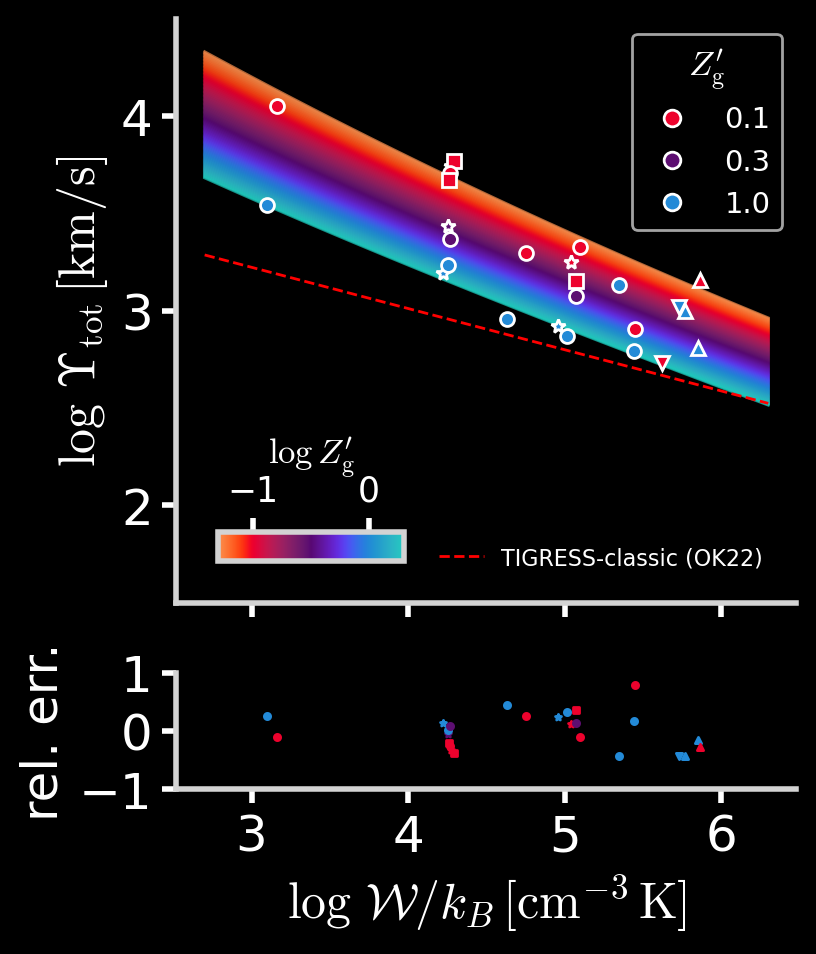

In [19]:
# Figure for total feedback yield compared with
# the model based on thermal + nonthermal (turbulent+magnetic)
fig, axes = plt.subplots(
    2, 1, sharex="col", figsize=(4, 5), gridspec_kw=dict(height_ratios=[1, 0.2])
)

x1, x2 = ["W", "Zgas"]

# fitting for thermal feedback yield
yf = "Yth"
odr_out = fit_odr(qdset, xf1=x1, xf2=x2, yf=yf)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset1 = get_model_odr(
    odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=Wmin, Wmax=Wmax, dims=[x2, x1]
)

# fitting for non-thermal feedback yield
yf = "Ynonth"
odr_out = fit_odr(qdset, xf1=x1, xf2=x2, yf=yf)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset2 = get_model_odr(
    odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=Wmin, Wmax=Wmax, dims=[x2, x1]
)

# get total feedback yield model by summing up two
model_dset = np.log10(10**model_dset1 + 10**model_dset2)

# plot results
plt.sca(axes[0])
plot_fitting_mean(qdset, model_dset, x1, "Ytot", legend=1, colorbar=3)
# plt.plot(pt_df[x1],pt_df['Ytot'],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
# plt.ylim((5.e1,2.e4))
plt.ylim(1.5, 4.5)

plt.sca(axes[1])
plot_fitting_mean(qdset, model_dset, x1, "Ytot", residual=True)

axes[0].set_xlabel("")
fig.axes[-1].xaxis.set_ticks_position("top")
fig.axes[-1].xaxis.set_label_position("top")
plt.setp(fig.axes[-1].get_xticklabels(), "fontsize", "x-small")
fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(), fontsize="x-small")


# add reference line from the previous result (Ostriker & Kim 2022 Eq 27, Figure 14)
w = model_dset.W.data
plt.sca(axes[0])
plt.plot(w, 3.86 - 0.212 * w, ls="--", color="r", lw=1)
leg1 = plt.gca().get_legend()
custom_lines2 = [Line2D([0], [0], ls="--", color="r", lw=1)]
leg2 = plt.legend(
    custom_lines2,
    ["TIGRESS-classic (OK22)"],
    loc=4,
    borderpad=1,
    fontsize=8,
    frameon=False,
)
plt.gca().add_artist(leg1)

plt.savefig(os.path.join(outdir, "Ytot_fit2.png"), bbox_inches="tight")

In [20]:
qdset_ = qdset.to_dataset("variable")
for yf in ["Ytot", "Yth", "Yturb", "Ymag", "oYmag", "dYmag"]:
    qdset_[yf] = (
        qdset_[yf.replace("Y", "Pi" if "mag" in yf else "P")]
        / qdset_["sfr"]
        * yield_conv
    )
qdset_["Ynonth"] = (qdset_["Pturb"] + qdset_["Pimag"]) / qdset_["sfr"] * yield_conv

Beta: [ 4.39421318 -0.28877513 -0.24014622]
Beta Std Error: [0.17855593 0.03556584 0.0558457 ]
Beta Covariance: [[ 2.06336032 -0.40109273  0.17269378]
 [-0.40109273  0.08186393 -0.01400352]
 [ 0.17269378 -0.01400352  0.20183944]]
Residual Variance: 0.01545160097638636
Inverse Condition #: 0.0032230112204930396
Reason(s) for Halting:
  Sum of squares convergence
Ytot
L1 : 0.23088359180173348
L2 : 0.3540018820752794
Beta: [ 4.4705036  -0.46344029 -0.49865193]
Beta Std Error: [0.11942298 0.02378579 0.03737026]
Beta Covariance: [[ 2.64534933 -0.51417972  0.22176285]
 [-0.51417972  0.1049403  -0.01799746]
 [ 0.22176285 -0.01799746  0.25903566]]
Residual Variance: 0.005391290936382638
Inverse Condition #: 0.003223353574104577
Reason(s) for Halting:
  Sum of squares convergence
Yth
L1 : 0.14657303233955868
L2 : 0.22409032669584325
Beta: [ 3.65526255 -0.21658939  0.00411601]
Beta Std Error: [0.21581867 0.04297578 0.06737946]
Beta Covariance: [[ 1.89509825 -0.36830439  0.15942811]
 [-0.36830439

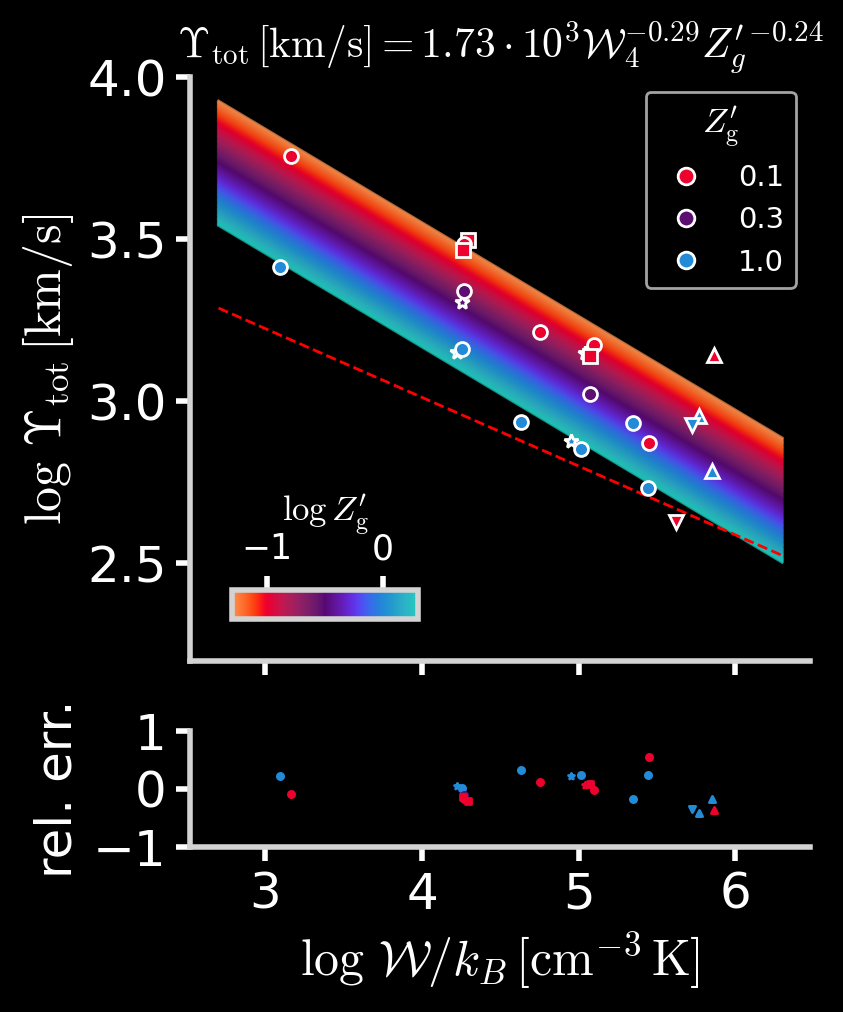

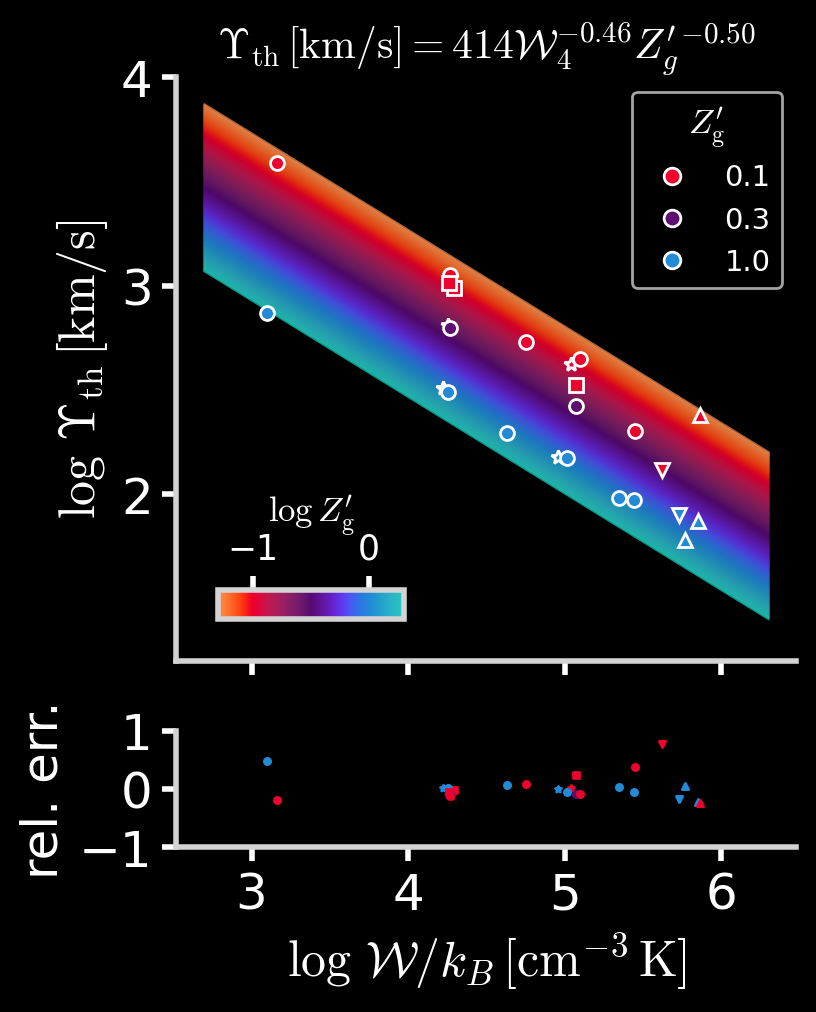

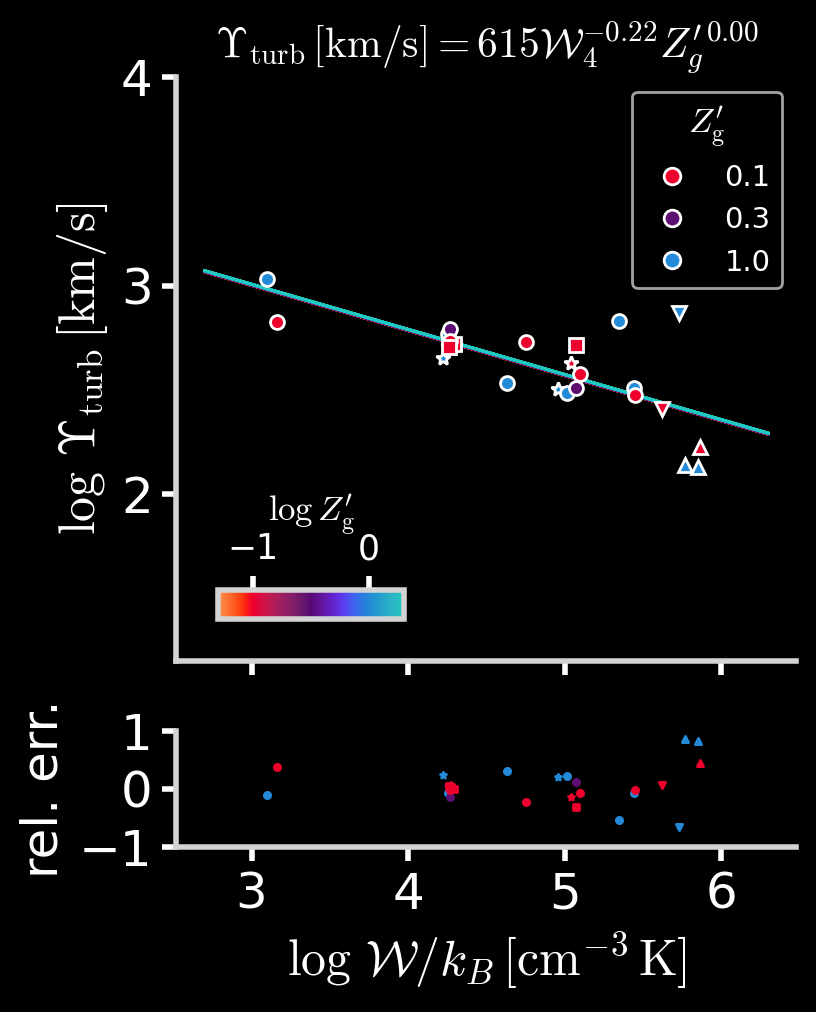

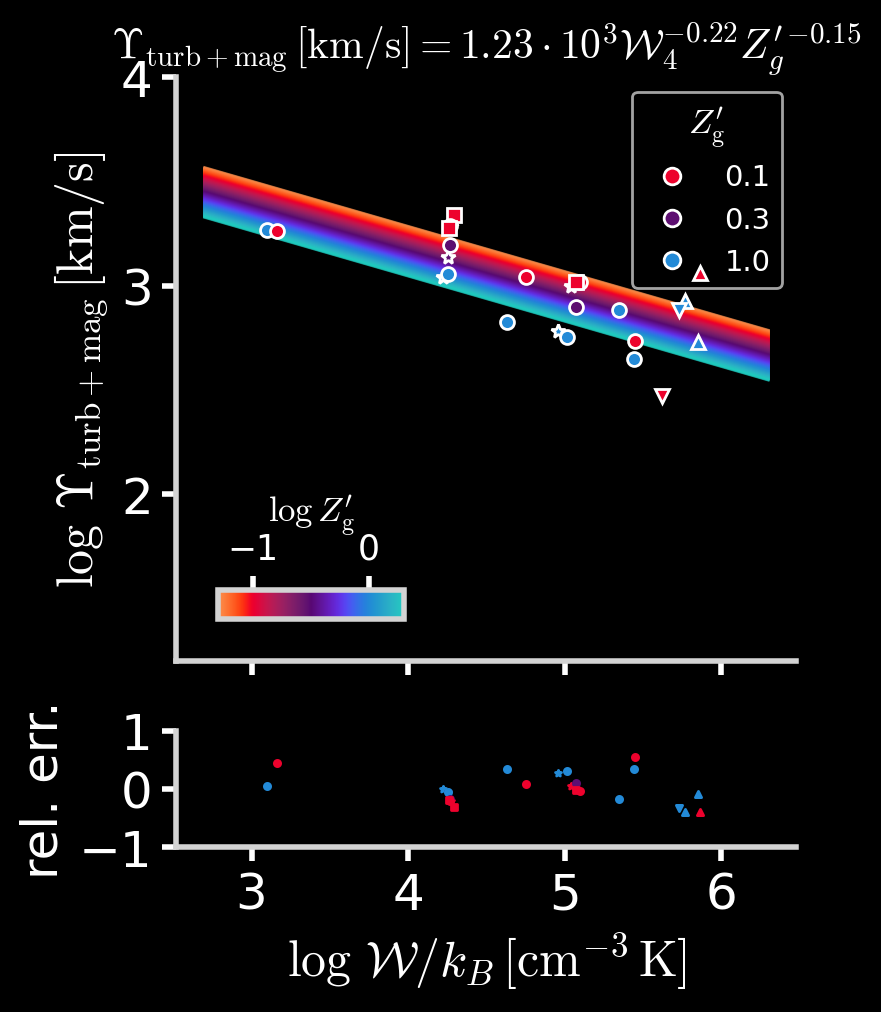

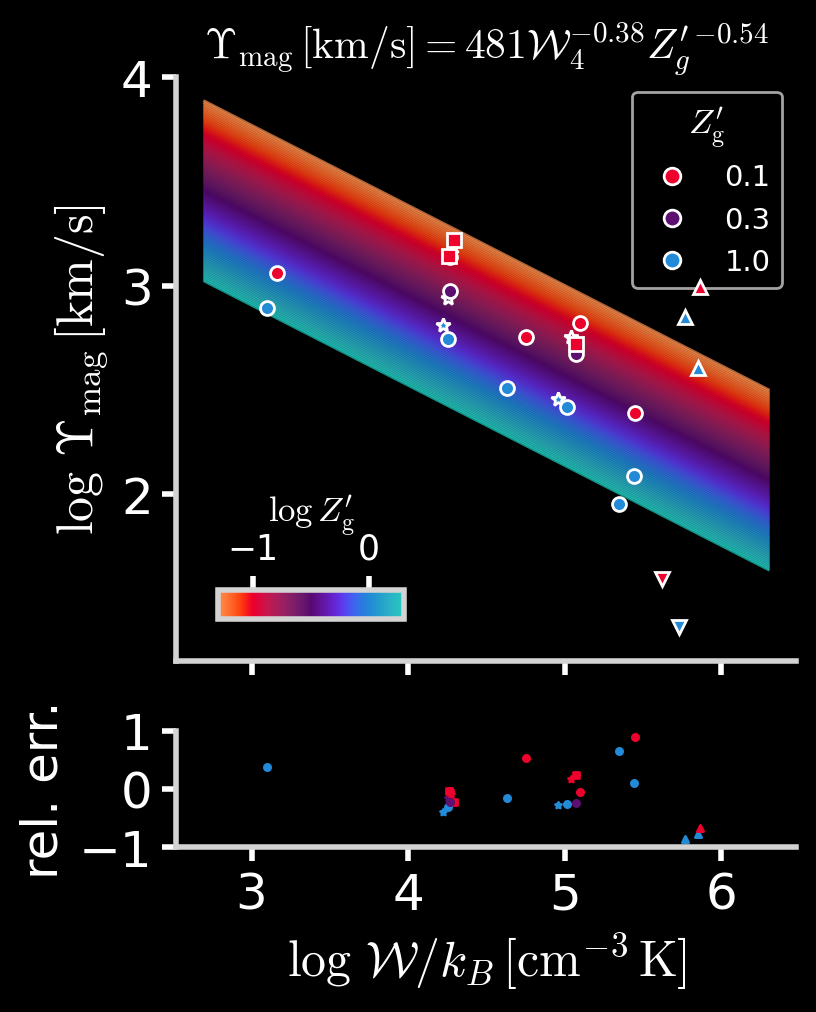

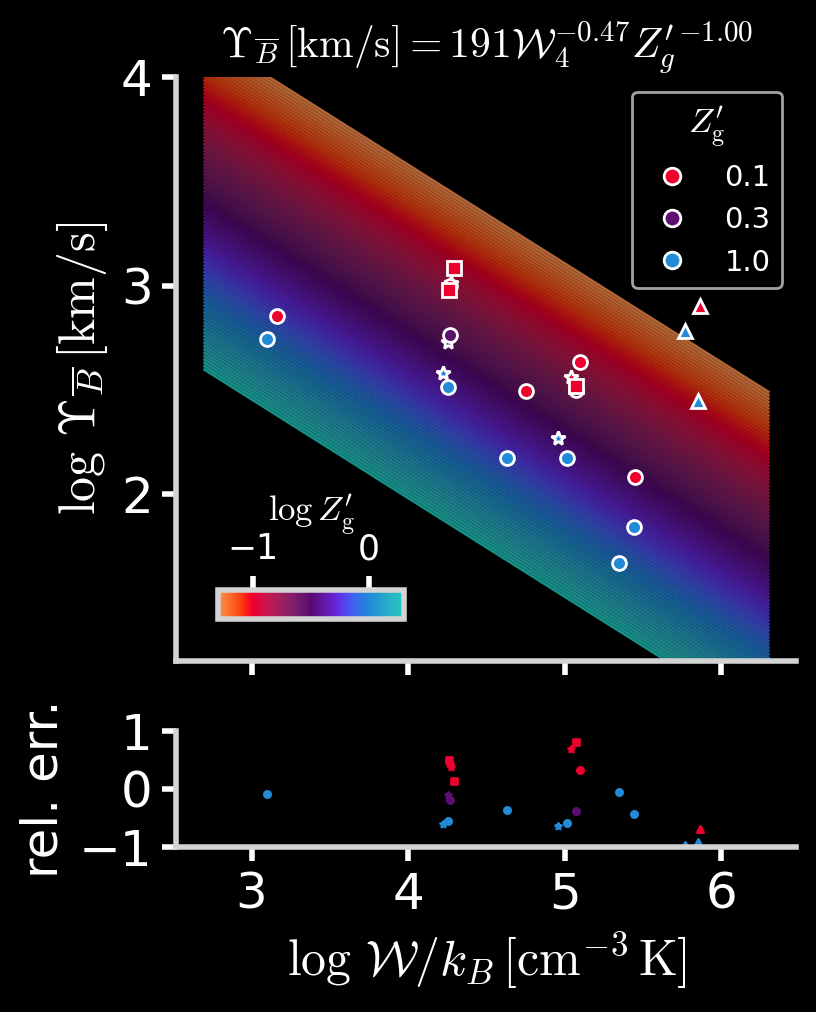

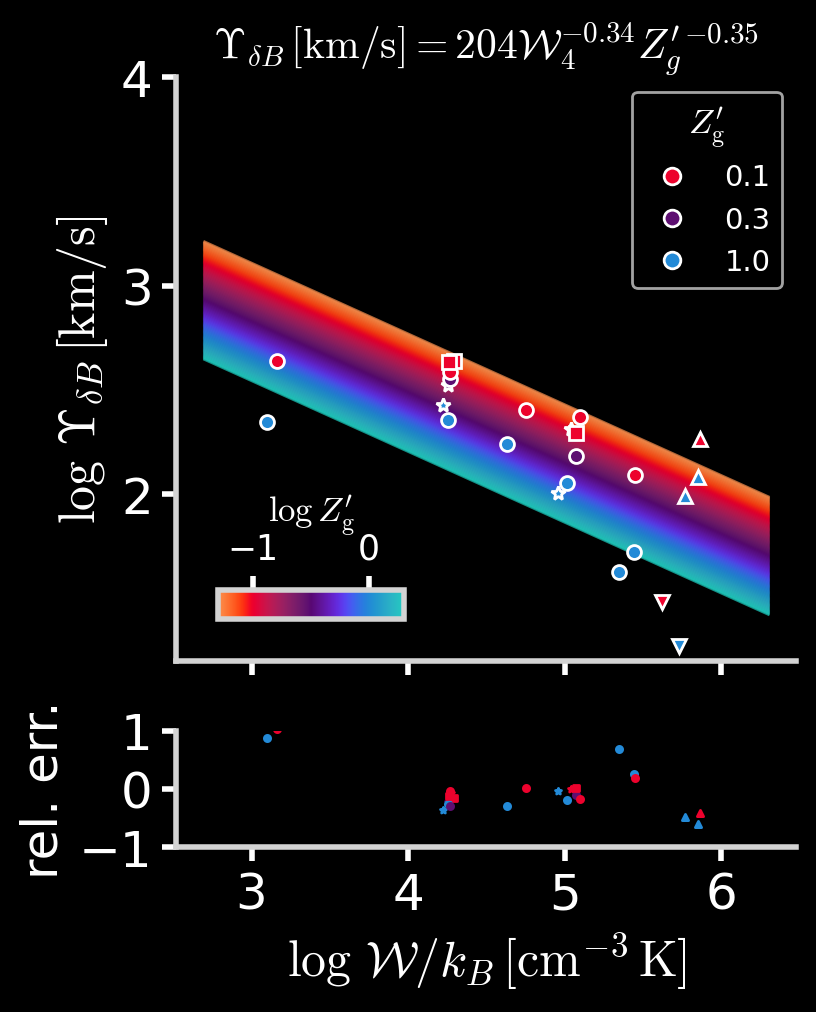

In [21]:
# Figure for feedback yields (each component saved into each figure)
for yf in ["Ytot", "Yth", "Yturb", "Ynonth", "Ymag", "oYmag", "dYmag"]:
    fig, axes = plt.subplots(
        2, 1, sharex="col", figsize=(4, 5), gridspec_kw=dict(height_ratios=[1, 0.2])
    )

    # set field names for x-axes and yaxis
    x1, x2 = ["W", "Zgas"]

    # linear regression
    odr_out = fit_odr(qdset_.to_array(), xf1=x1, xf2=x2, yf=yf)
    # construct model (not the x1-axis is not W and the parameter range is changed)
    model_dset = get_model_odr(
        odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=Wmin, Wmax=Wmax, dims=[x2, x1]
    )

    # plot simulation data along with fitting result
    plt.sca(axes[0])

    # write fitting result as the axis title
    a = odr_out.beta[1]
    b = odr_out.beta[2]
    Y0 = 10 ** odr_out.beta[0] * 1.0e4**a
    tit = (
        labels[yf]
        + f"$={scifmt(Y0)} \\mathcal{{W}}_4^{{{a:5.2f}}}{{Z_g^\\prime}}^{{{b:5.2f}}}$"
    )
    plt.title(tit, fontsize="small")

    # call plotting script
    plot_fitting_mean(
        qdset_.to_array(), model_dset, x1, yf, legend=1, colorbar=3, model=True
    )
    # plot all data as grey dots
    # plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
    plt.ylim((1.2, 4.0))
    if yf == "Ytot":
        plt.ylim((2.2, 4.0))
    plt.xlabel("")

    # plot residual compared with the fitting result
    plt.sca(axes[1])
    print(yf)
    plot_fitting_mean(qdset_.to_array(), model_dset, x1, yf, residual=True, model=True)

    # decorate axis
    fig.axes[-1].xaxis.set_ticks_position("top")
    fig.axes[-1].xaxis.set_label_position("top")
    plt.setp(fig.axes[-1].get_xticklabels(), "fontsize", "x-small")
    fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(), fontsize="x-small")

    # TIGRESS-classic
    if yf == "Ytot":
        w = model_dset.W.data
        plt.sca(axes[0])
        plt.plot(w, 3.86 - 0.212 * w, ls="--", color="r", lw=1)
    # save figure
    plt.savefig(os.path.join(outdir, f"{yf}_mean_fit.png"), bbox_inches="tight")

Beta: [ 4.4705036  -0.46344029 -0.49865193]
Beta Std Error: [0.11942298 0.02378579 0.03737026]
Beta Covariance: [[ 2.64534933 -0.51417972  0.22176285]
 [-0.51417972  0.1049403  -0.01799746]
 [ 0.22176285 -0.01799746  0.25903566]]
Residual Variance: 0.005391290936382638
Inverse Condition #: 0.003223353574104577
Reason(s) for Halting:
  Sum of squares convergence
Beta: [ 3.95746128 -0.2169085  -0.14962115]
Beta Std Error: [0.19773098 0.03938137 0.0618049 ]
Beta Covariance: [[ 1.93380214 -0.37587813  0.16211631]
 [-0.37587813  0.07670863 -0.01320441]
 [ 0.16211631 -0.01320441  0.18893326]]
Residual Variance: 0.020217963040326154
Inverse Condition #: 0.003222428706535465
Reason(s) for Halting:
  Sum of squares convergence
L1 : 0.21583572441054064
L2 : 0.3379271017057027


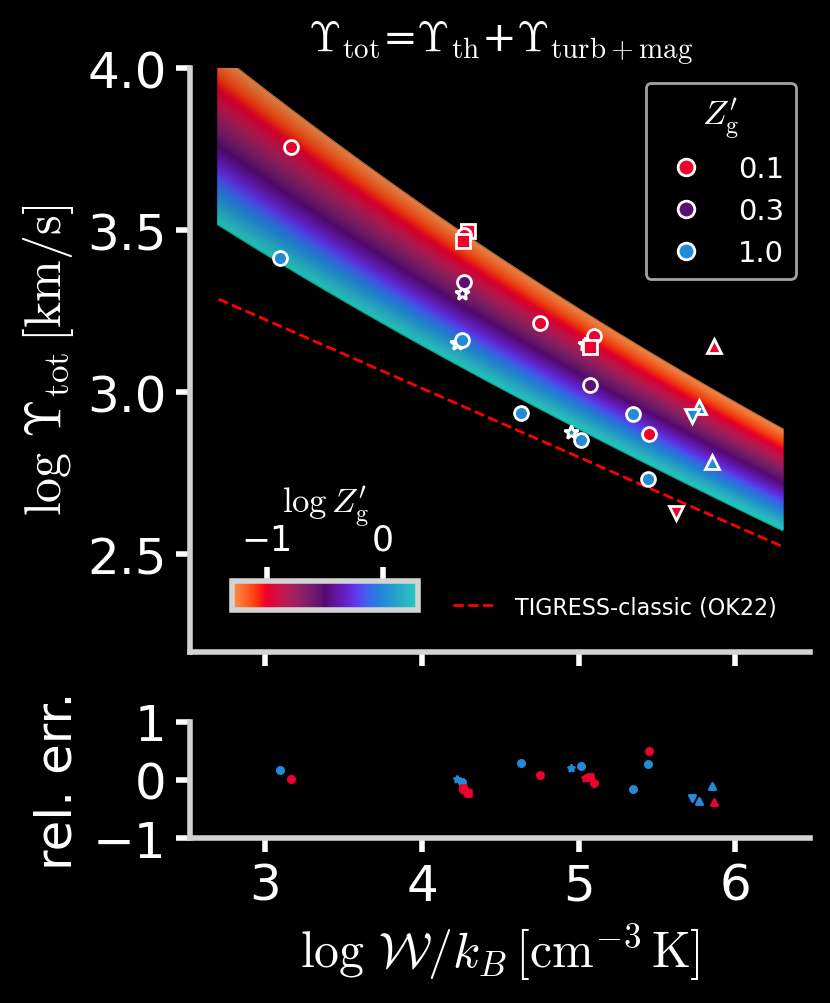

In [22]:
# Figure for total feedback yield compared with
# the model based on thermal + nonthermal (turbulent+magnetic)
fig, axes = plt.subplots(
    2, 1, sharex="col", figsize=(4, 5), gridspec_kw=dict(height_ratios=[1, 0.2])
)

x1, x2 = ["W", "Zgas"]

# fitting for thermal feedback yield
yf = "Yth"
odr_out = fit_odr(qdset_.to_array(), xf1=x1, xf2=x2, yf=yf)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset1 = get_model_odr(
    odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=Wmin, Wmax=Wmax, dims=[x2, x1]
)

# fitting for non-thermal feedback yield
yf = "Ynonth"
odr_out = fit_odr(qdset_.to_array(), xf1=x1, xf2=x2, yf=yf)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset2 = get_model_odr(
    odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=Wmin, Wmax=Wmax, dims=[x2, x1]
)

# get total feedback yield model by summing up two
model_dset = np.log10(10**model_dset1 + 10**model_dset2)

# plot results
plt.sca(axes[0])
plot_fitting_mean(qdset_.to_array(), model_dset, x1, "Ytot", legend=1, colorbar=3)
# plt.plot(pt_df[x1],pt_df['Ytot'],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
# plt.ylim((5.e1,2.e4))
plt.ylim(2.2, 4.0)
tit = labels["Ytot"][:-16] + "=" + labels["Yth"][:-16] + "+" + labels["Ynonth"][:-16]
plt.title(tit, fontsize="small")

plt.sca(axes[1])
plot_fitting_mean(qdset_.to_array(), model_dset, x1, "Ytot", residual=True)

axes[0].set_xlabel("")
fig.axes[-1].xaxis.set_ticks_position("top")
fig.axes[-1].xaxis.set_label_position("top")
plt.setp(fig.axes[-1].get_xticklabels(), "fontsize", "x-small")
fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(), fontsize="x-small")


# add reference line from the previous result (Ostriker & Kim 2022 Eq 27, Figure 14)
w = model_dset.W.data
plt.sca(axes[0])
plt.plot(w, 3.86 - 0.212 * w, ls="--", color="r", lw=1)
leg1 = plt.gca().get_legend()
custom_lines2 = [Line2D([0], [0], ls="--", color="r", lw=1)]
leg2 = plt.legend(
    custom_lines2,
    ["TIGRESS-classic (OK22)"],
    loc=4,
    borderpad=1,
    fontsize=8,
    frameon=False,
)
plt.gca().add_artist(leg1)

plt.savefig(os.path.join(outdir, "Ytot_mean_fit2.png"), bbox_inches="tight")

In [23]:
# fitting for thermal feedback yield
yf = "Yturb"
odr_out = fit_odr(qdset_.to_array(), xf1=x1, xf2=x2, yf=yf)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dsett = get_model_odr(
    odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=Wmin, Wmax=Wmax, dims=[x2, x1]
)

Beta: [ 3.65526255 -0.21658939  0.00411601]
Beta Std Error: [0.21581867 0.04297578 0.06737946]
Beta Covariance: [[ 1.89509825 -0.36830439  0.15942811]
 [-0.36830439  0.07514522 -0.01310319]
 [ 0.15942811 -0.01310319  0.18471779]]
Residual Variance: 0.02457798595324543
Inverse Condition #: 0.0032194310061313437
Reason(s) for Halting:
  Sum of squares convergence


Beta: [-5.10724327  2.37666484  0.27784634]
Beta Std Error: [0.20698849 0.13300014 0.09565118]
Beta Covariance: [[ 3.78248991 -2.25102128  0.64714572]
 [-2.25102128  1.56167106 -0.1214712 ]
 [ 0.64714572 -0.1214712   0.80772977]]
Residual Variance: 0.011326992451315654
Inverse Condition #: 0.017730159448588433
Reason(s) for Halting:
  Sum of squares convergence


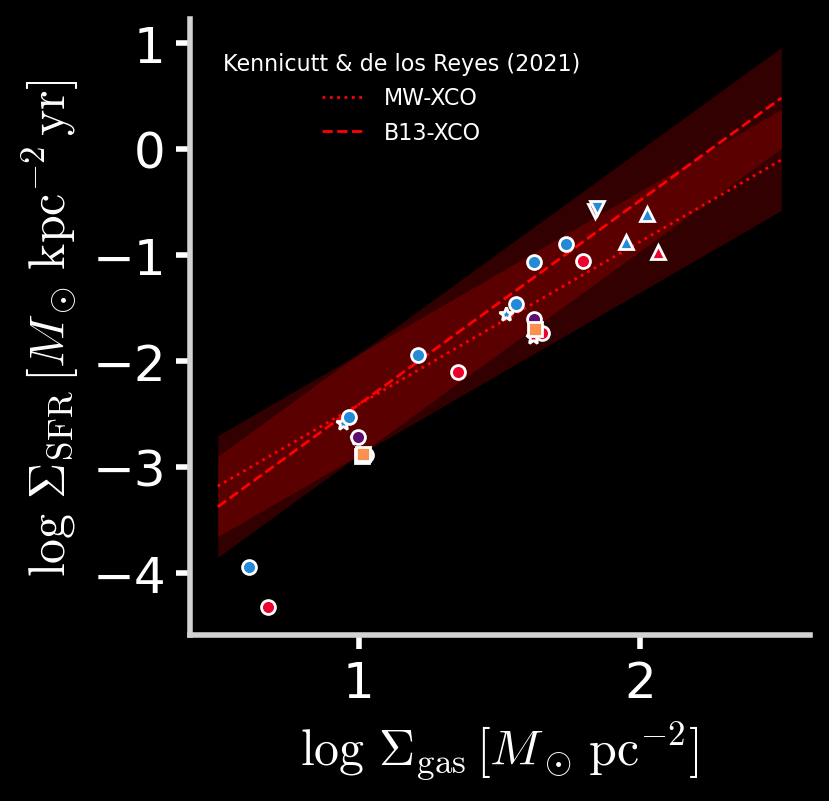

In [24]:
# Figure for weight and Ptot showing off parameter coverage
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# set field names for x-axes and yaxis
# here we fit Ptot as a function of nH and Zgas
x1, x2, yf = ["Sigma_gas", "Zdust", "sfr"]

# linear regression
odr_out = fit_odr(qdset_.to_array(), xf1=x1, xf2=x2, yf=yf)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset = get_model_odr(
    odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=0.5, Wmax=2.5, dims=[x2, x1]
)

# plot simulation data along with fitting result
plt.sca(ax)
# call plotting script
plot_fitting_mean(qdset_.to_array(), model_dset, x1, yf, model=False, legend=1)
# plot_fitting_points(qdset,model_dset,x1,yf,legend=4,colorbar=0,model=False)
# plot all data as grey dots
# plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
Sigma = 10.0**model_dset.Sigma_gas.data
KS_sfr1 = Sigma**1.54 * 10 ** (-3.95)
KS_sfr2 = Sigma**1.93 * 10 ** (-4.34)
plt.plot(np.log10(Sigma), np.log10(KS_sfr1), ls=":", color="r", lw=1)
plt.fill_between(
    np.log10(Sigma),
    np.log10(KS_sfr1) - np.log10(3),
    np.log10(KS_sfr1) + np.log10(3),
    color="r",
    alpha=0.2,
    lw=0,
)
plt.plot(np.log10(Sigma), np.log10(KS_sfr2), ls="--", color="r", lw=1)
plt.fill_between(
    np.log10(Sigma),
    np.log10(KS_sfr2) - np.log10(3),
    np.log10(KS_sfr2) + np.log10(3),
    color="r",
    alpha=0.2,
    lw=0,
)

# leg1=plt.gca().get_legend()
custom_lines2 = [
    Line2D([0], [0], ls=":", color="r", lw=1),
    Line2D([0], [0], ls="--", color="r", lw=1),
]
leg2 = plt.legend(
    custom_lines2,
    ["MW-XCO", "B13-XCO"],
    title="Kennicutt & de los Reyes (2021)",
    title_fontsize=8,
    loc=2,
    borderpad=1,
    fontsize=8,
    frameon=False,
)
# plt.gca().add_artist(leg1)
# # decorate axis
# fig.axes[-1].xaxis.set_ticks_position('top')
# fig.axes[-1].xaxis.set_label_position('top')
# plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
# fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')

# save figure
plt.savefig(os.path.join(outdir, "KS.png"), bbox_inches="tight", dpi=300)

In [25]:
W_sfr_conv = ((ac.k_B * au.K / au.cm**3) / (au.km / au.s)).to("M_sun/kpc^2/yr").value

Beta: [-8.20943865  1.32879914  0.23251094]
Beta Std Error: [0.20687822 0.04118065 0.05311021]
Beta Covariance: [[ 5.17232194 -1.00689632  0.37282145]
 [-1.00689632  0.20494744 -0.03559945]
 [ 0.37282145 -0.03559945  0.34088827]]
Residual Variance: 0.008274542494796224
Inverse Condition #: 0.0031834174977422446
Reason(s) for Halting:
  Sum of squares convergence


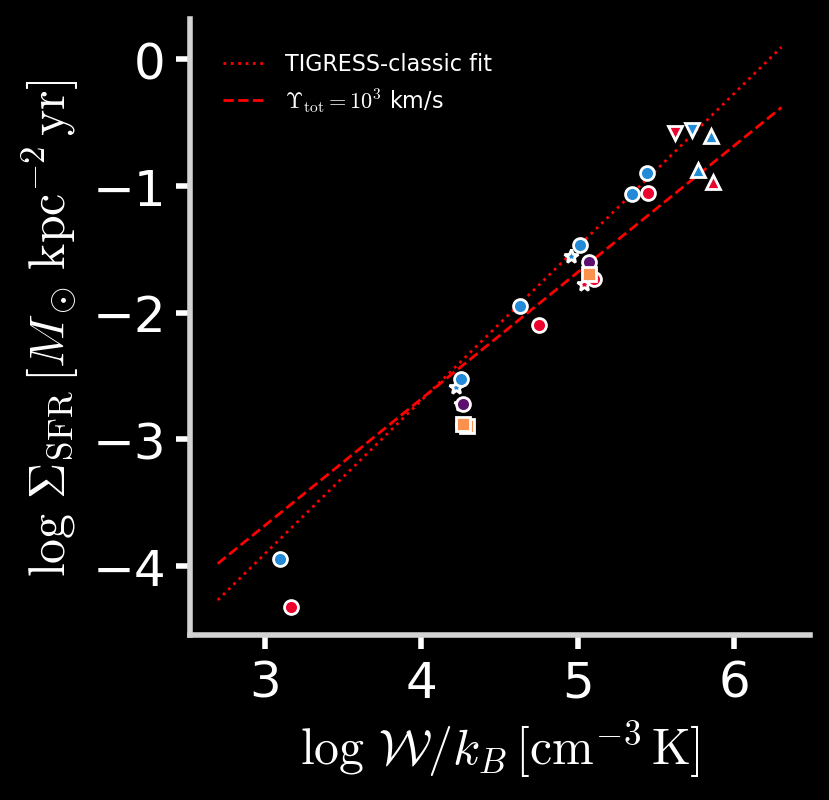

In [26]:
# Figure for weight and Ptot showing off parameter coverage
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# set field names for x-axes and yaxis
# here we fit Ptot as a function of nH and Zgas
x1, x2, yf = ["W", "Zdust", "sfr"]

# linear regression
odr_out = fit_odr(qdset_.to_array(), xf1=x1, xf2=x2, yf=yf)
# construct model (not the x1-axis is not W and the parameter range is changed)
model_dset = get_model_odr(
    odr_out, Zmin=Zmin, Zmax=Zmax, Wmin=Wmin, Wmax=Wmax, dims=[x2, x1]
)

# plot simulation data along with fitting result
plt.sca(ax)
# call plotting script
plot_fitting_mean(qdset_.to_array(), model_dset, x1, yf, model=False, legend=1)
# plot_fitting_points(qdset,model_dset,x1,yf,legend=4,colorbar=0,model=False)
# plot all data as grey dots
# plt.plot(pt_df[x1],pt_df[yf],'.',color='grey',alpha=0.1,mew=0,zorder=-1)
W = model_dset.W.data
plt.plot(W, W + np.log10(W_sfr_conv / 1.0e3), ls="--", color="r", lw=1)
plt.plot(W, W + np.log10(W_sfr_conv) - 3.86 + 0.212 * (W), ls=":", color="r", lw=1)
# leg1=plt.gca().get_legend()
custom_lines2 = [
    Line2D([0], [0], ls=":", color="r", lw=1),
    Line2D([0], [0], ls="--", color="r", lw=1),
]
leg2 = plt.legend(
    custom_lines2,
    [r"TIGRESS-classic fit", r"$\Upsilon_{\rm tot}=10^3$ km/s"],
    loc=2,
    borderpad=1,
    fontsize=8,
    frameon=False,
)
# plt.gca().add_artist(leg1)
# # decorate axis
# fig.axes[-1].xaxis.set_ticks_position('top')
# fig.axes[-1].xaxis.set_label_position('top')
# plt.setp(fig.axes[-1].get_xticklabels(),'fontsize','x-small')
# fig.axes[-1].set_xlabel(fig.axes[-1].get_xlabel(),fontsize='x-small')
# plt.xlim(1.e3,1.e6)
# plt.ylim(1.e-4,1)
# save figure
plt.savefig(os.path.join(outdir, "PRFM.png"), bbox_inches="tight")

In [27]:
# from pyathena.plt_tools.utils import texteffect


# def plot_box_comparison(sa,ms,ts,wf,reduced=None,legend=[0.1,.95]):
#     if len(np.atleast_1d(ts)) == 1: ts = [ts]*len(ms)
#     tf = 'nH'
#     nmodel = len(ms)
#     w = 0.8/nmodel
#     offset = np.arange(nmodel+1)/nmodel*0.8-0.4 + 0.5*w
#     edge_color = plt.rcParams['axes.edgecolor']
#     for i,m in enumerate(ms):
#         s = sa.set_model(m)
#         data, colors, labels = plot_1Dpdf_tevol(getattr(s.pdf,tf)[wf].sel(time=ts[i]), s.pdf.phdef,
#                                                 reduced=wf if reduced is None else reduced)
#         box=plt.boxplot(data,positions=np.arange(len(data))+offset[i],widths=w,
#                         whis=[16,84],showfliers=False,
#                         patch_artist=True,medianprops=dict(color=edge_color),
# #                         showmeans=True,
# #                         meanprops=dict(markerfacecolor='tab:orange',markeredgecolor='w',
# #                                        markersize=5,markeredgewidth=0.5,
# #                                        marker='*')
#                        )

#         for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
#             plt.setp(box[element], color=edge_color)
#         plt.setp(box['boxes'],'facecolor',pdata.colors[m])
# #         pdata.colors[m]='C{}'.format(i)
#         s.color = pdata.colors[m]
#         if legend:
#             x0=0.95
#             dx=0.015
#             y0=0.95
#             dy=0.08

#             c = s.color
#             plt.annotate('             ',(x0,y0-dy*i),xycoords='axes fraction',
#                          ha='center',va='top',size=8,
#                          backgroundcolor=c,color=c)
#             plt.annotate(m.replace('_','-'),(x0,y0-dy*i),xycoords='axes fraction',
#                          ha='center',va='top',**texteffect(8,linewidth=2, foreground=plt.rcParams['axes.facecolor']))
#     plt.xticks(ticks=np.arange(len(labels)),labels=labels)
#     for d, c, l, xc in zip(data, colors, labels, np.arange(len(data))):
#         plt.axvspan(xc-0.5,xc+0.5,color=c,alpha=0.3,lw=0)
# #     plt.yscale('log')
#     plt.ylim(0,1)
#     plt.xlim(-0.5,len(data)-0.5)


In [28]:
# s = pdata.sa.set_model(pdata.mlist[0])

In [29]:
# zp = s.read_zprof_new(flist=['A','d'])
# shorthands = s.get_phase_shorthand()
# rename_dict=dict()
# for i,pname in enumerate(shorthands):
#     rename_dict['phase{}'.format(i+1)] = pname
# zp = zp.to_array().to_dataset('phase').rename(rename_dict)
# torb = s.torb_Myr
# if s.torb_Myr <50:
#     trange = slice(torb*5,torb*15)
# elif s.torb_Myr >300:
#     trange = slice(torb*1.5,torb*5)
# else:
#     trange = slice(torb*2,torb*5)
# zp = zp.to_array('phase').to_dataset('variable').sel(z=slice(-300,300),time=trange)
# zpw = zp.sel(phase=['c','u','w1','w2','h1','h2']).sum(dim='phase')
# zp_Cold = zp.sel(phase=['cmm','cnm']).sum(dim='phase')
# zp_UNM = zp.sel(phase=['unm','uim']).sum(dim='phase')
# zp_ph = zp.sel(phase=['wnm','wpim','wcim','h1','h2'])
# zp_ph = xr.concat([zp_Cold.assign_coords(phase=['Cold']),zp_UNM.assign_coords(phase=['unm']),zp_ph],dim='phase')
# volume=(zp_ph['A'].sum(dim='z')/zpw['A'].sum(dim='z')).quantile([0.16,0.5,0.84],dim='time')
# mass=(zp_ph['d'].sum(dim='z')/zpw['d'].sum(dim='z')).quantile([0.16,0.5,0.84],dim='time')